In [1]:
import numpy as np
import mpmath as mat
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc

In [2]:
rcParams['savefig.dpi'] = 300
rcParams['figure.dpi'] = 300
# rcParams['font.family'] = 'Lucida Bright'
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

### Storm profile function

In [4]:
def stormprof(t,a=0.060,b=1.026,D=19):
    x=t/D
    z=b*x
    y = (1-a**z)/(1-a)
    return y

### Precipitation input creation (data per 5 minutes)

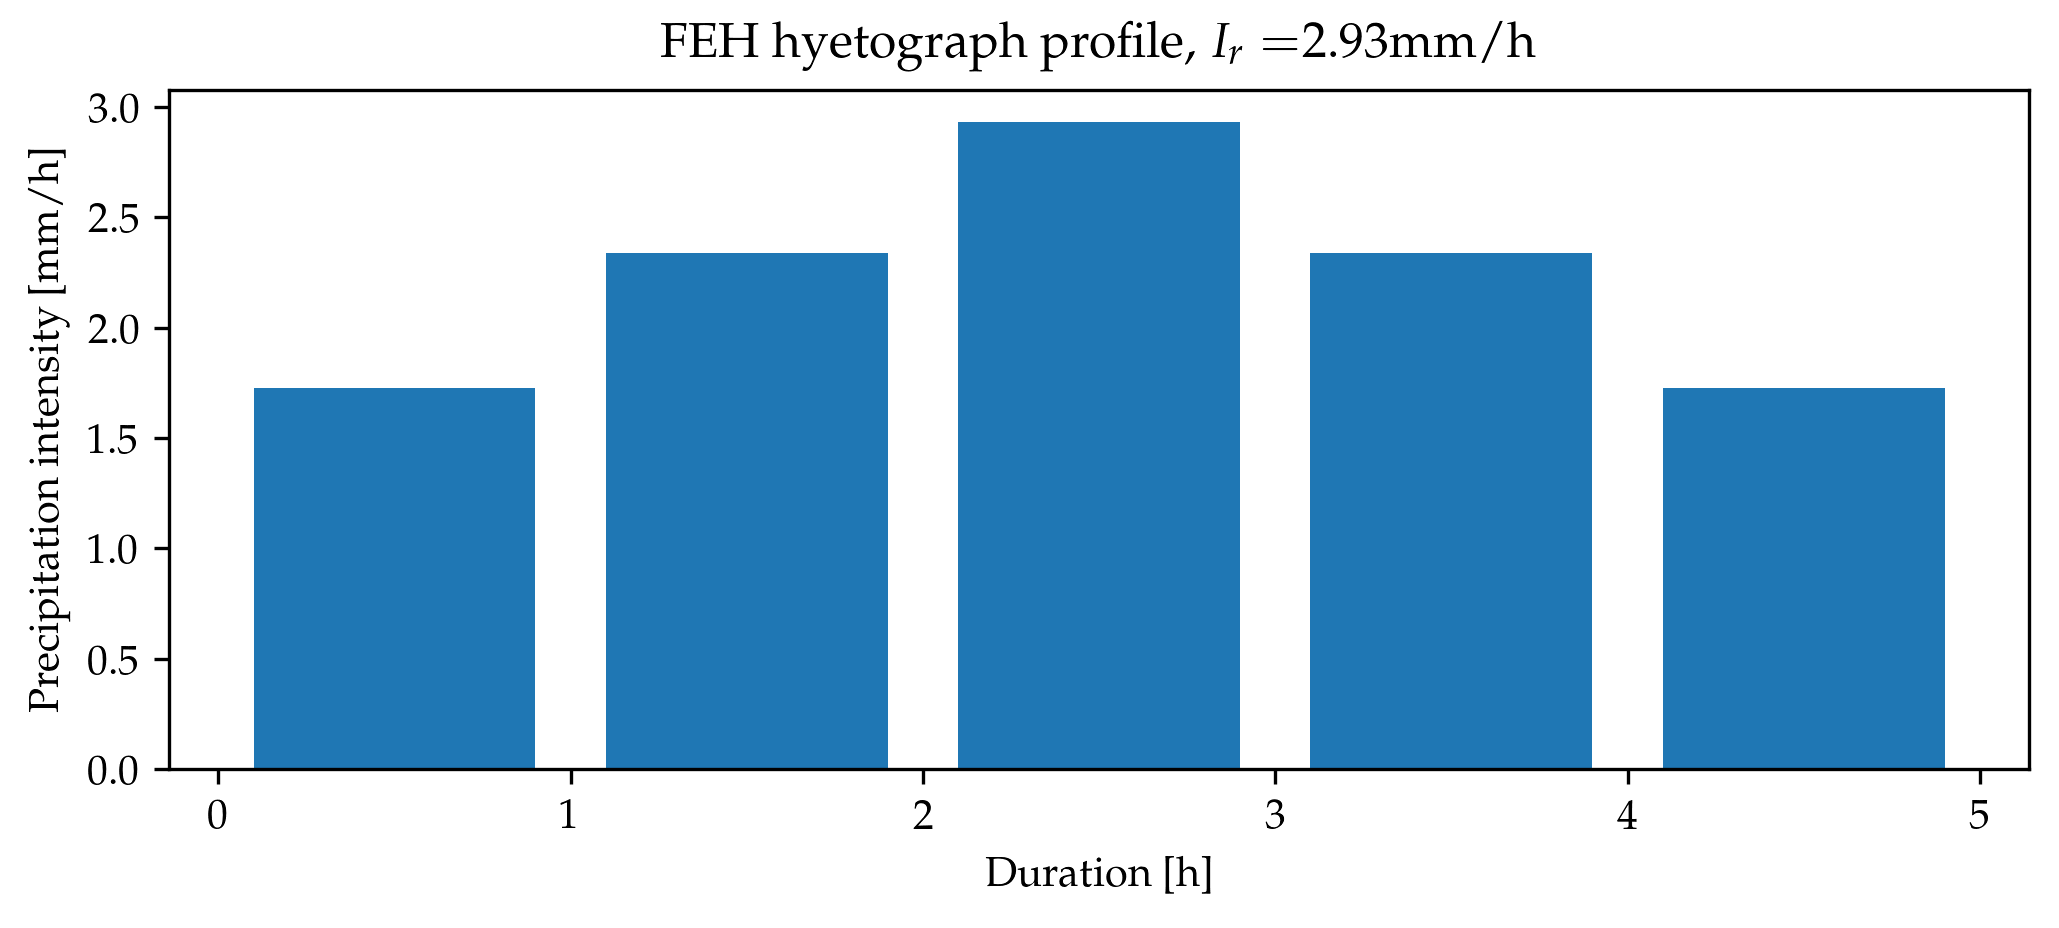

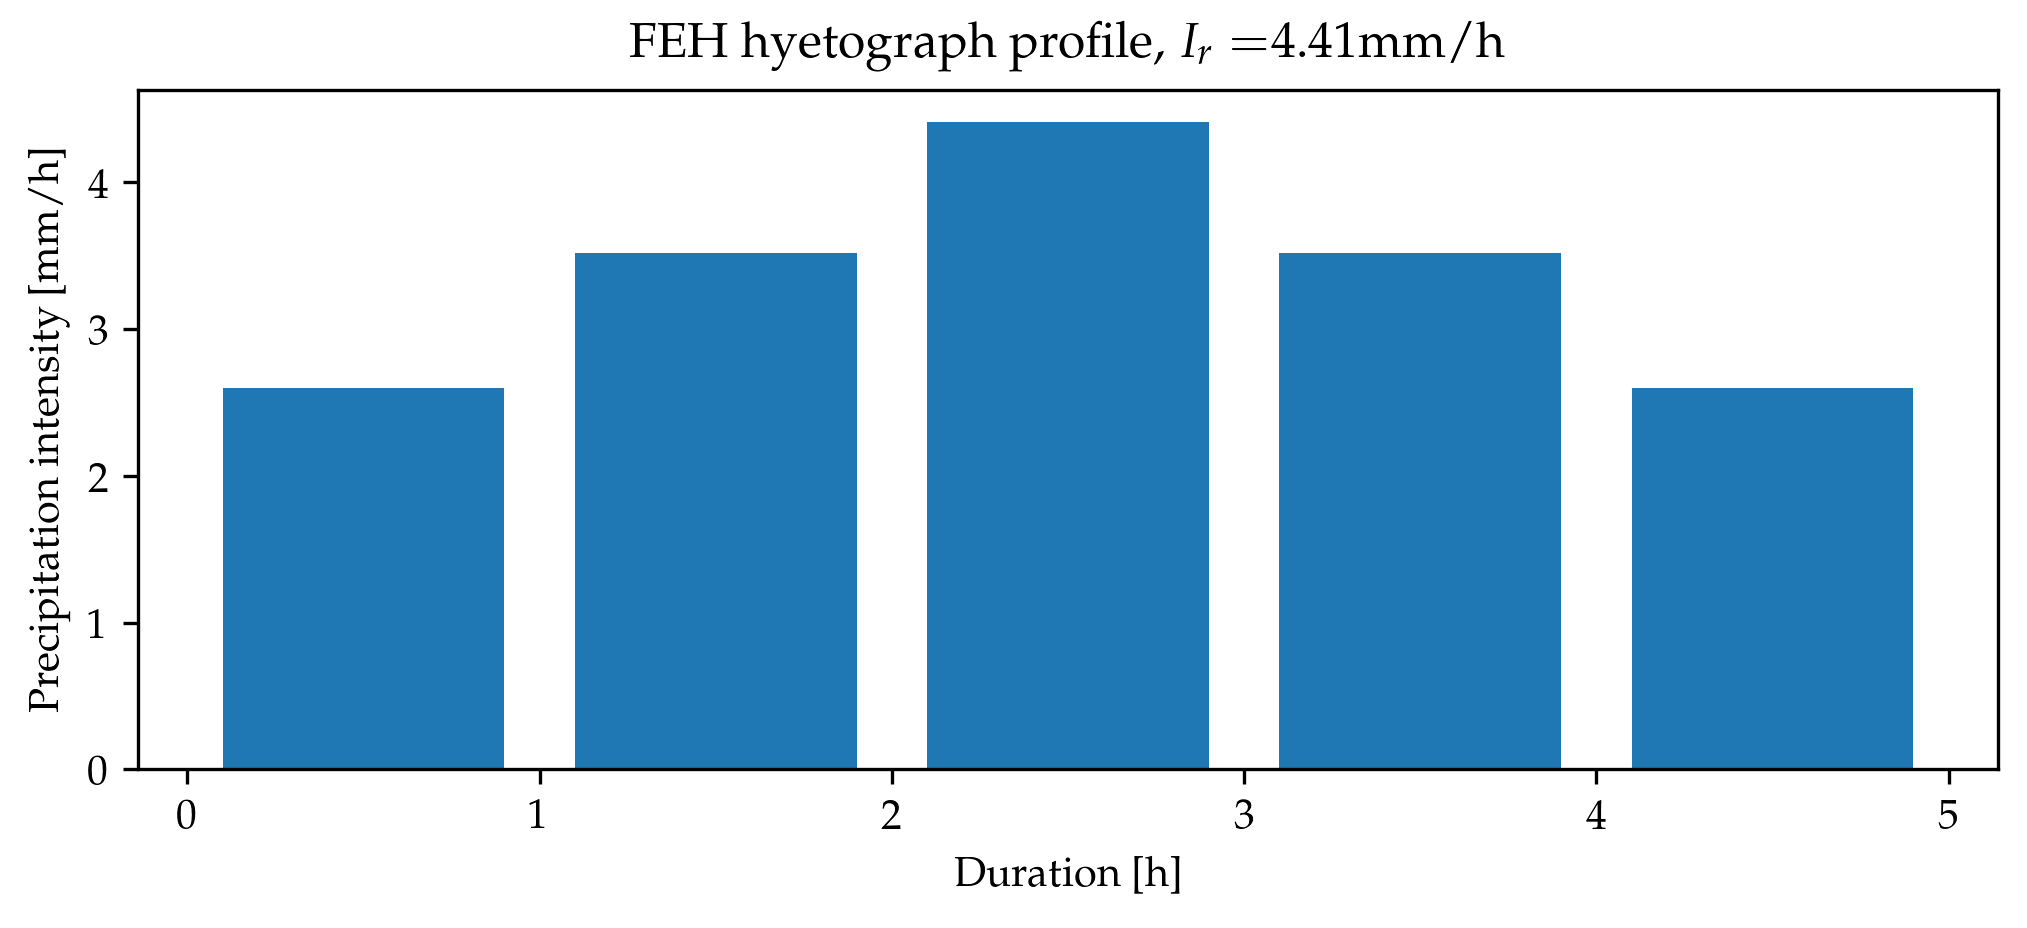

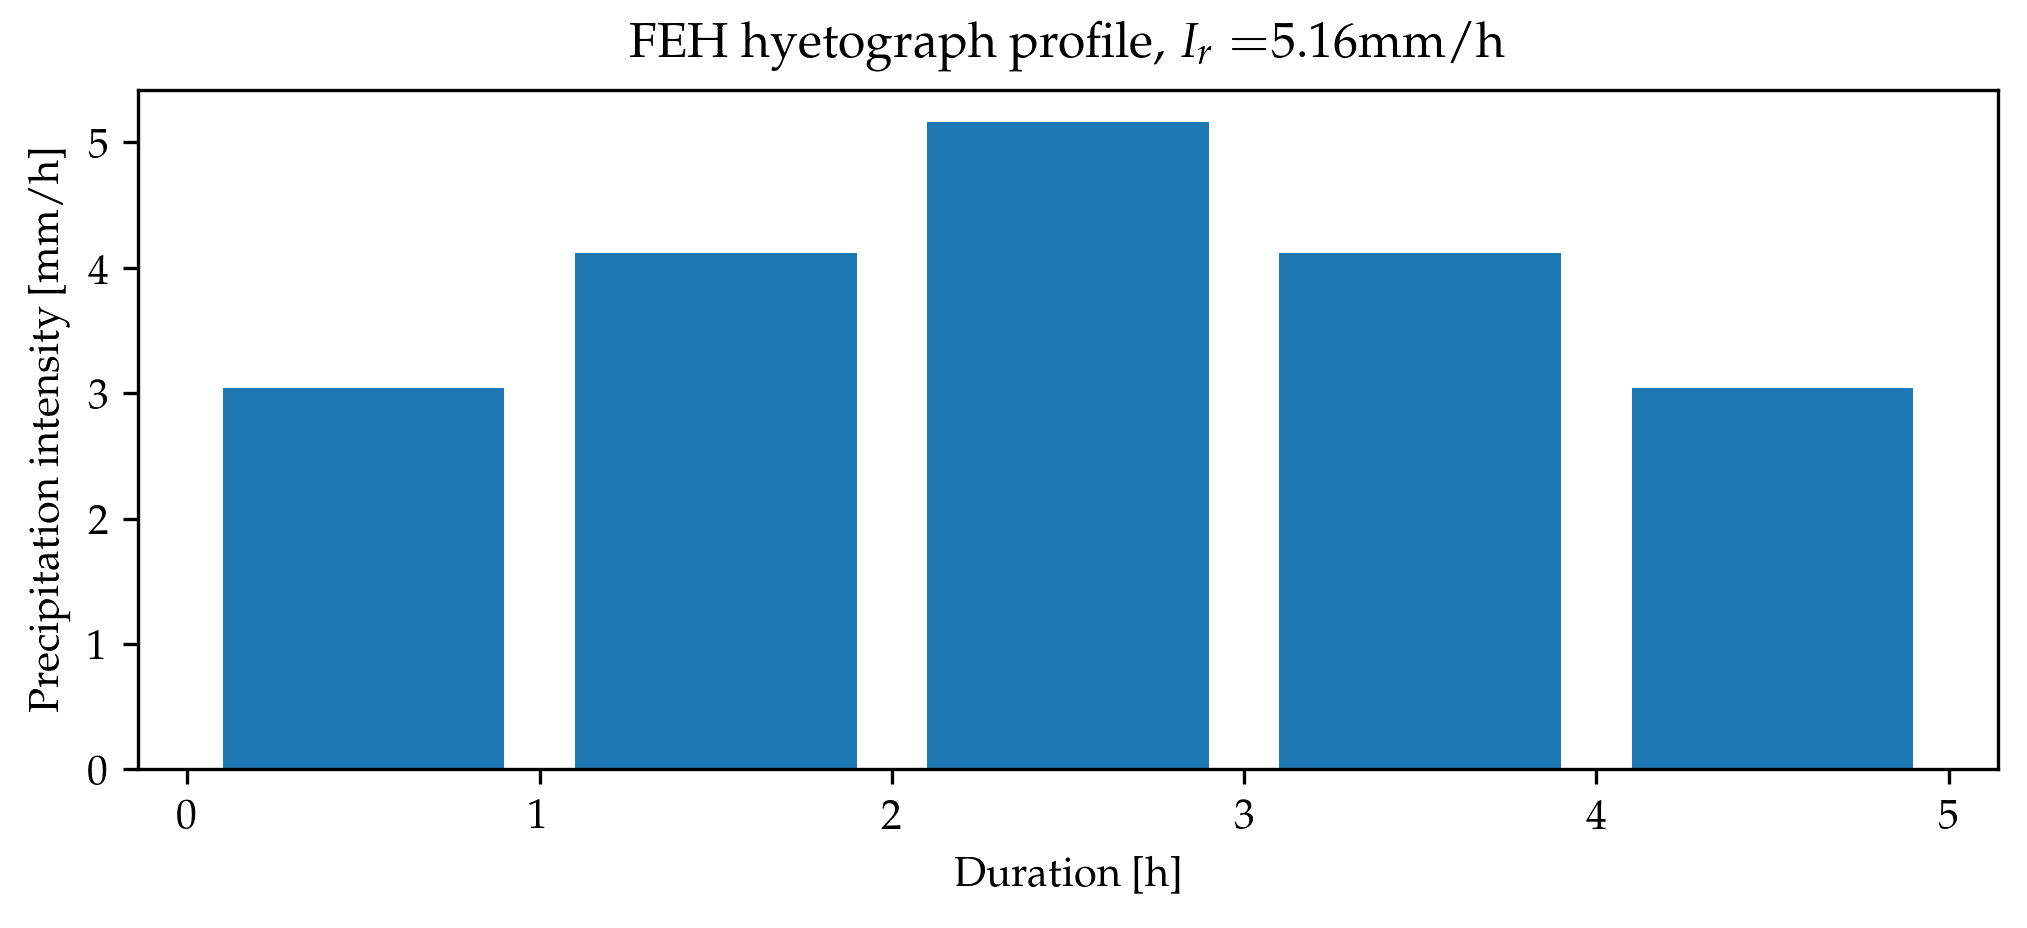

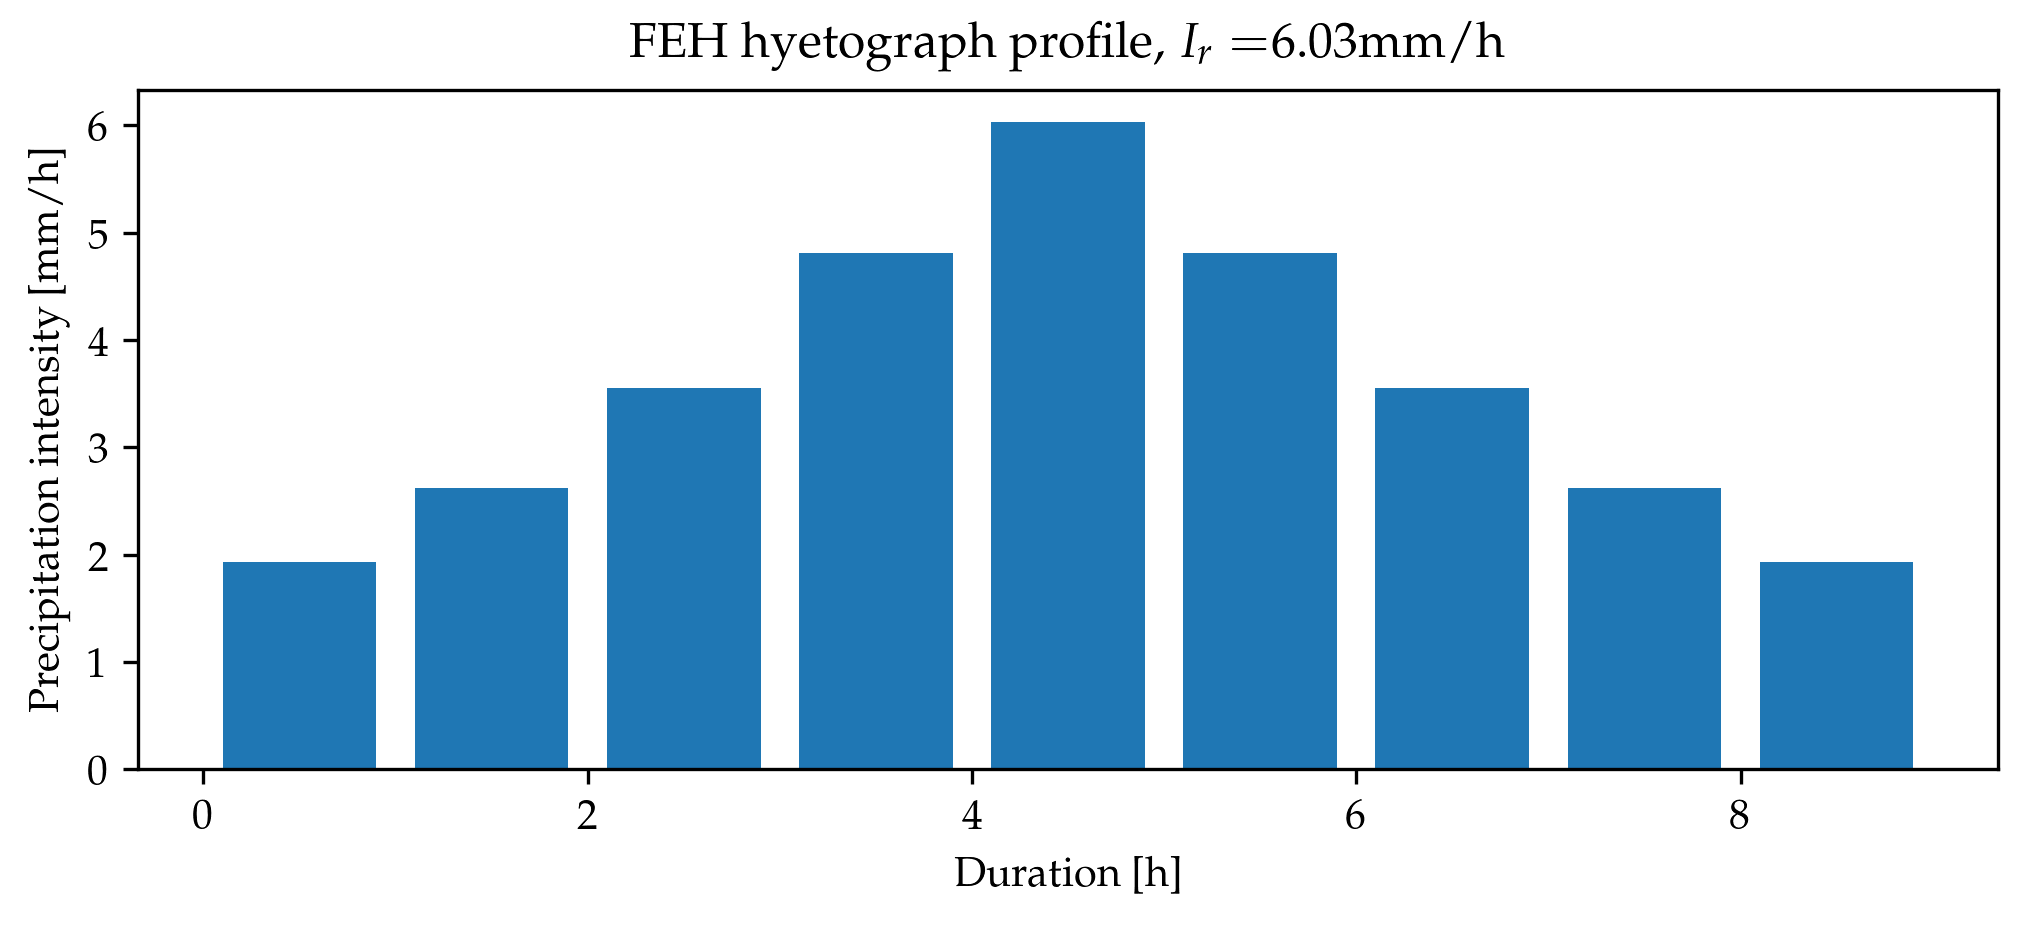

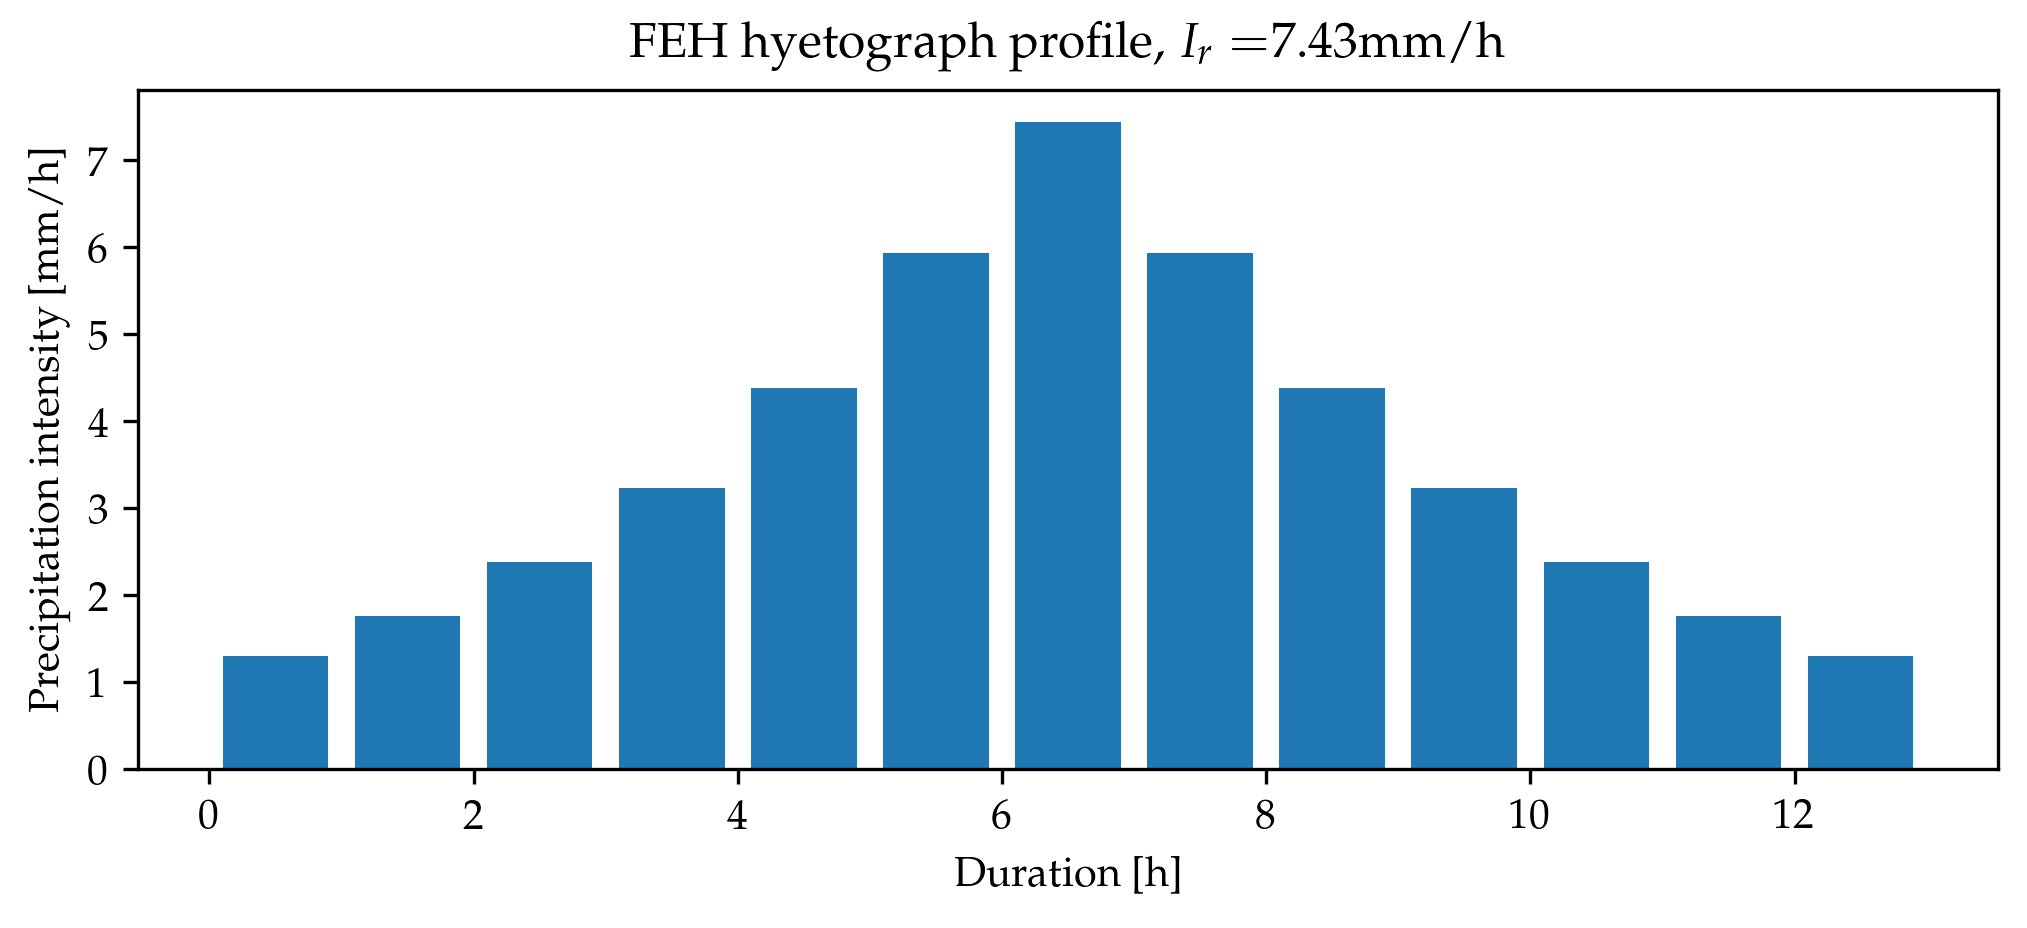

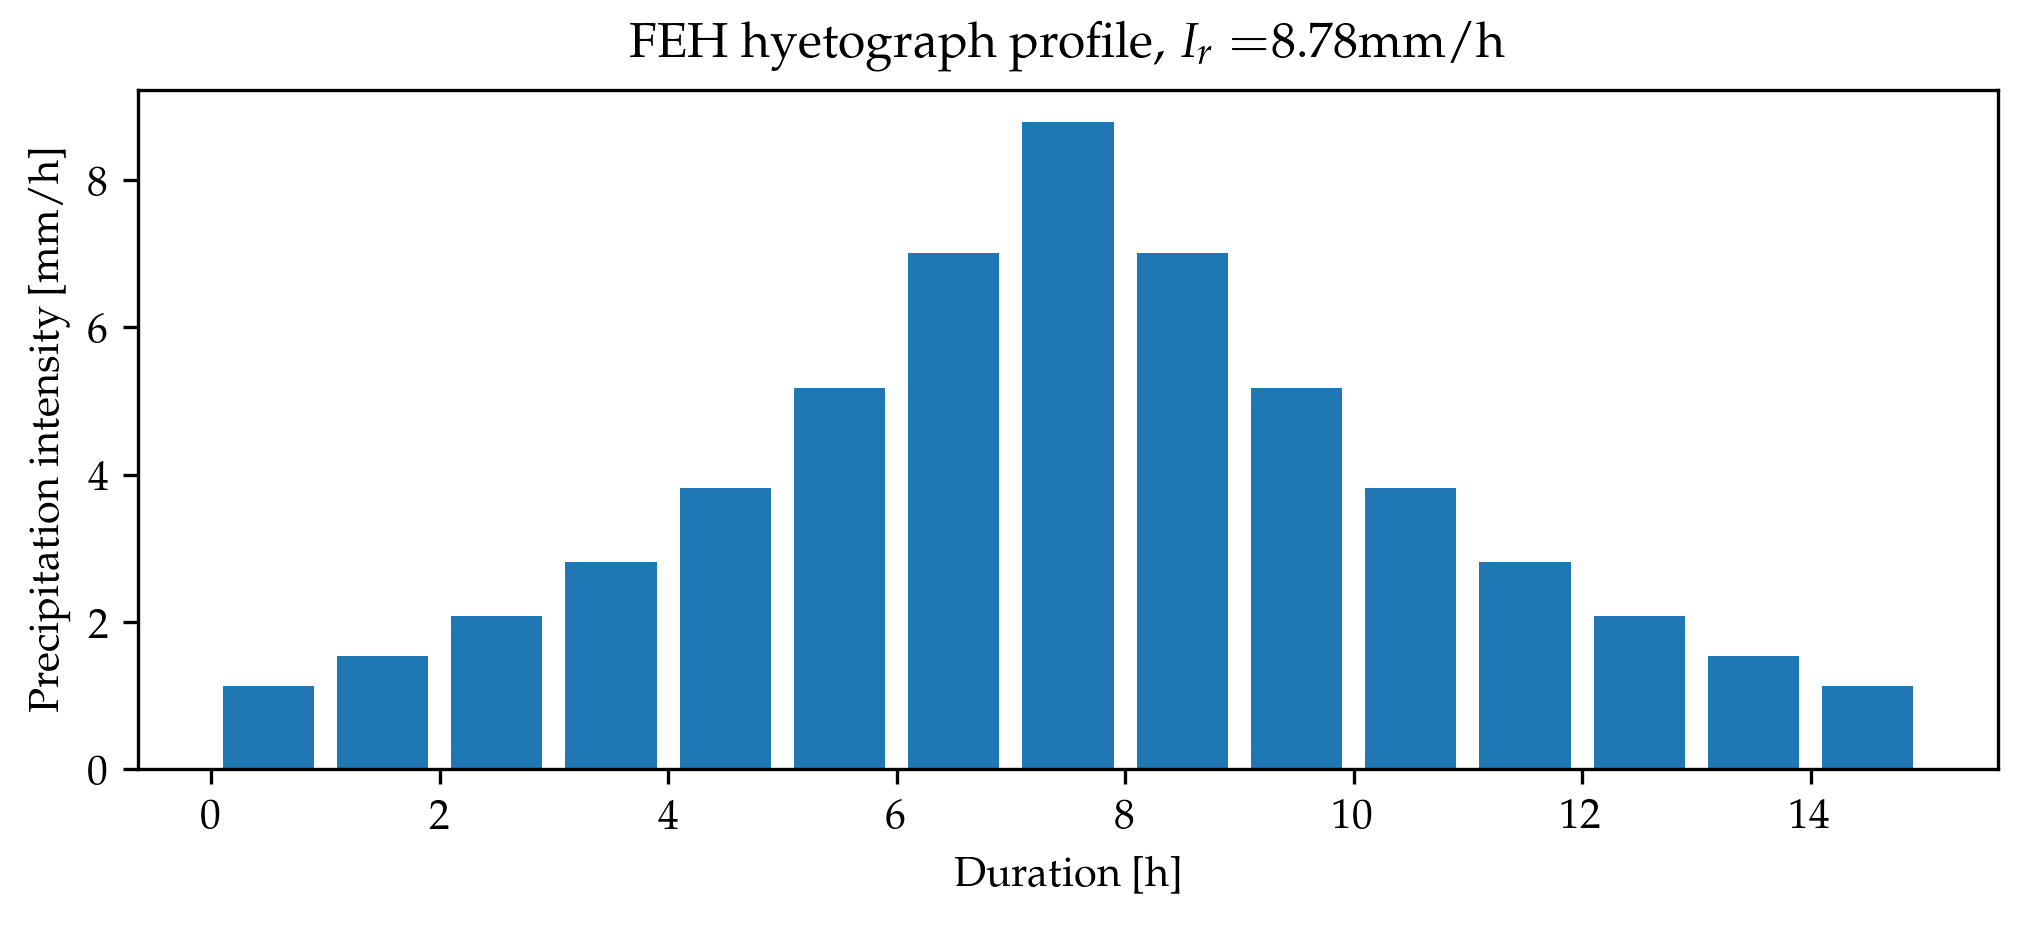

In [6]:
P_max = 0,2.93,4.41,5.16,6.03,7.43,8.78, 0s
D_coast = 43 # -1 later on
D = 0,5,5,5,9,13,15,0
P_list = []
for sc in range(len(P_max)):
    if (P_max[sc]!=0):
        block_prof_coast = np.zeros(D_coast)
        block_prof = np.zeros(D[sc])
        block_prof[int((D[sc]-1)/2)] = stormprof(1)
        for i in range(int((D[sc]-1)/2)):
            block_prof[int(D[sc]/2+1)+i], block_prof[int(D[sc]/2-1)-i] = (stormprof(3+2*i)- stormprof(1+2*i))/2*np.ones(2)
        block_prof *= P_max[sc]/stormprof(1)
        block_prof_coast[int(len(block_prof_coast)/2 - len(block_prof)/2):int(len(block_prof_coast)/2 + len(block_prof)/2)] = block_prof

        block_prof_long = []
        for i in range(len(block_prof_coast)):
            for j in range(12):
                block_prof_long.append(block_prof_coast[i])
#         block_prof_coast = 
        block_prof_long.append(block_prof_coast[i])
        P_list.append(block_prof_long[6:-6])# minus the 1 hour
        
        plt.figure(figsize=[8,3])
        plt.bar(np.arange(D[sc])+.5,block_prof)
        plt.title('FEH hyetograph profile, $I_r=$'+str(P_max[sc])+'mm/h')
        plt.xlabel("Duration [h]")
        plt.ylabel("Precipitation intensity [mm/h]")
    else:
        P_list.append(0)

In [128]:
sum(block_prof)

55.91424996924893

# Scenario input

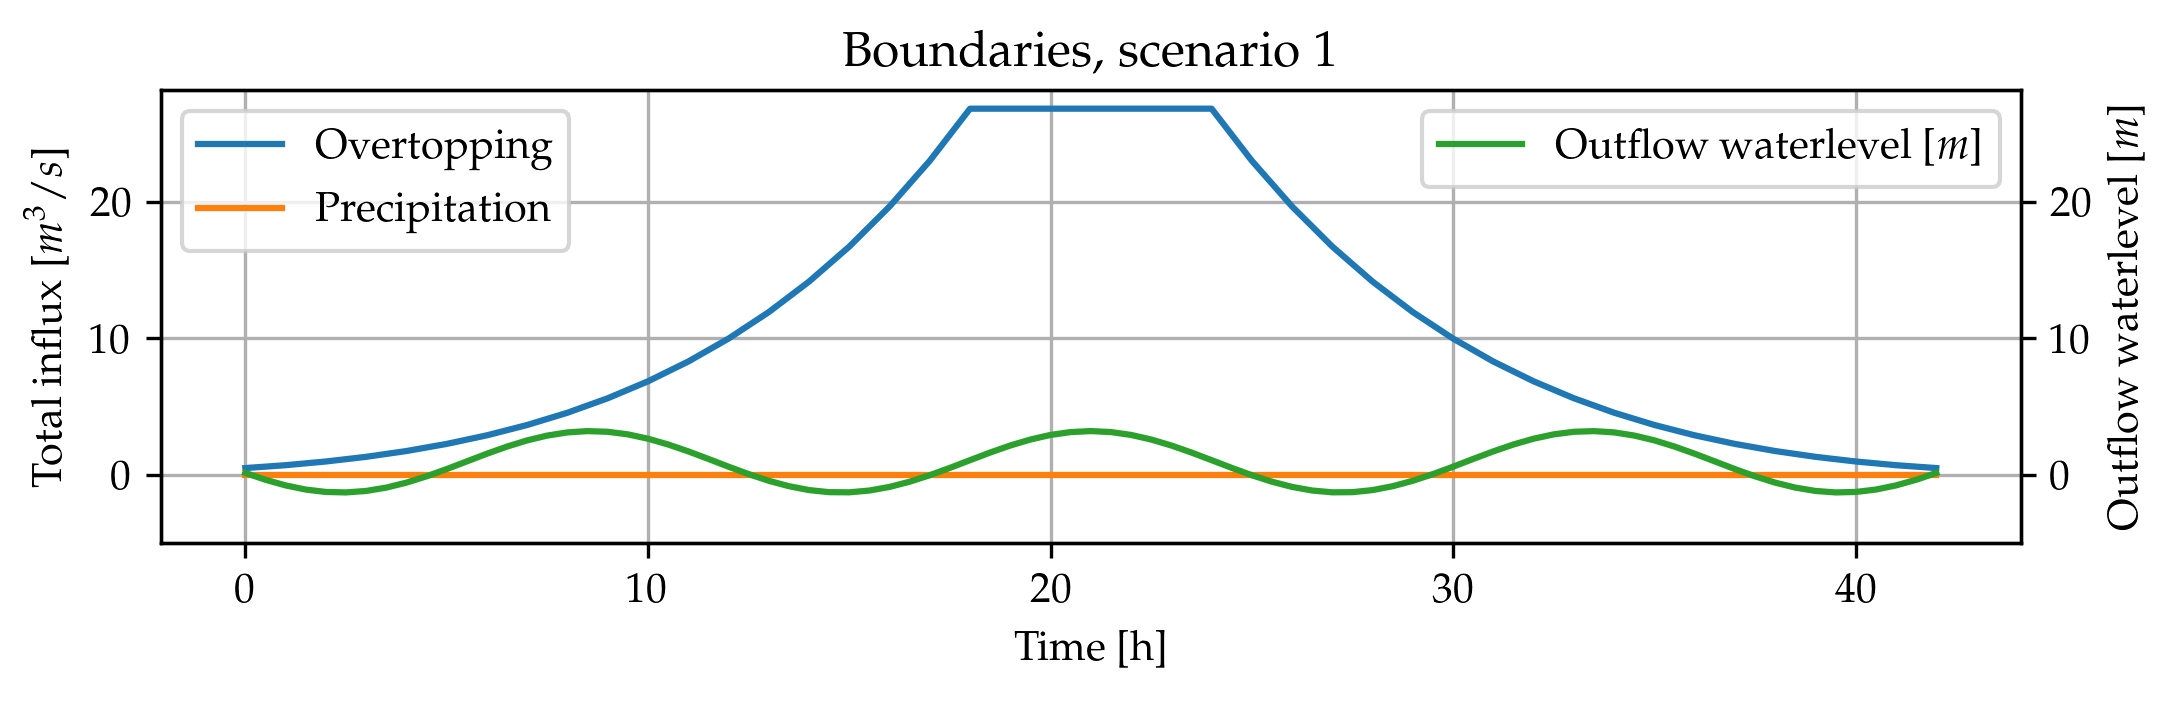

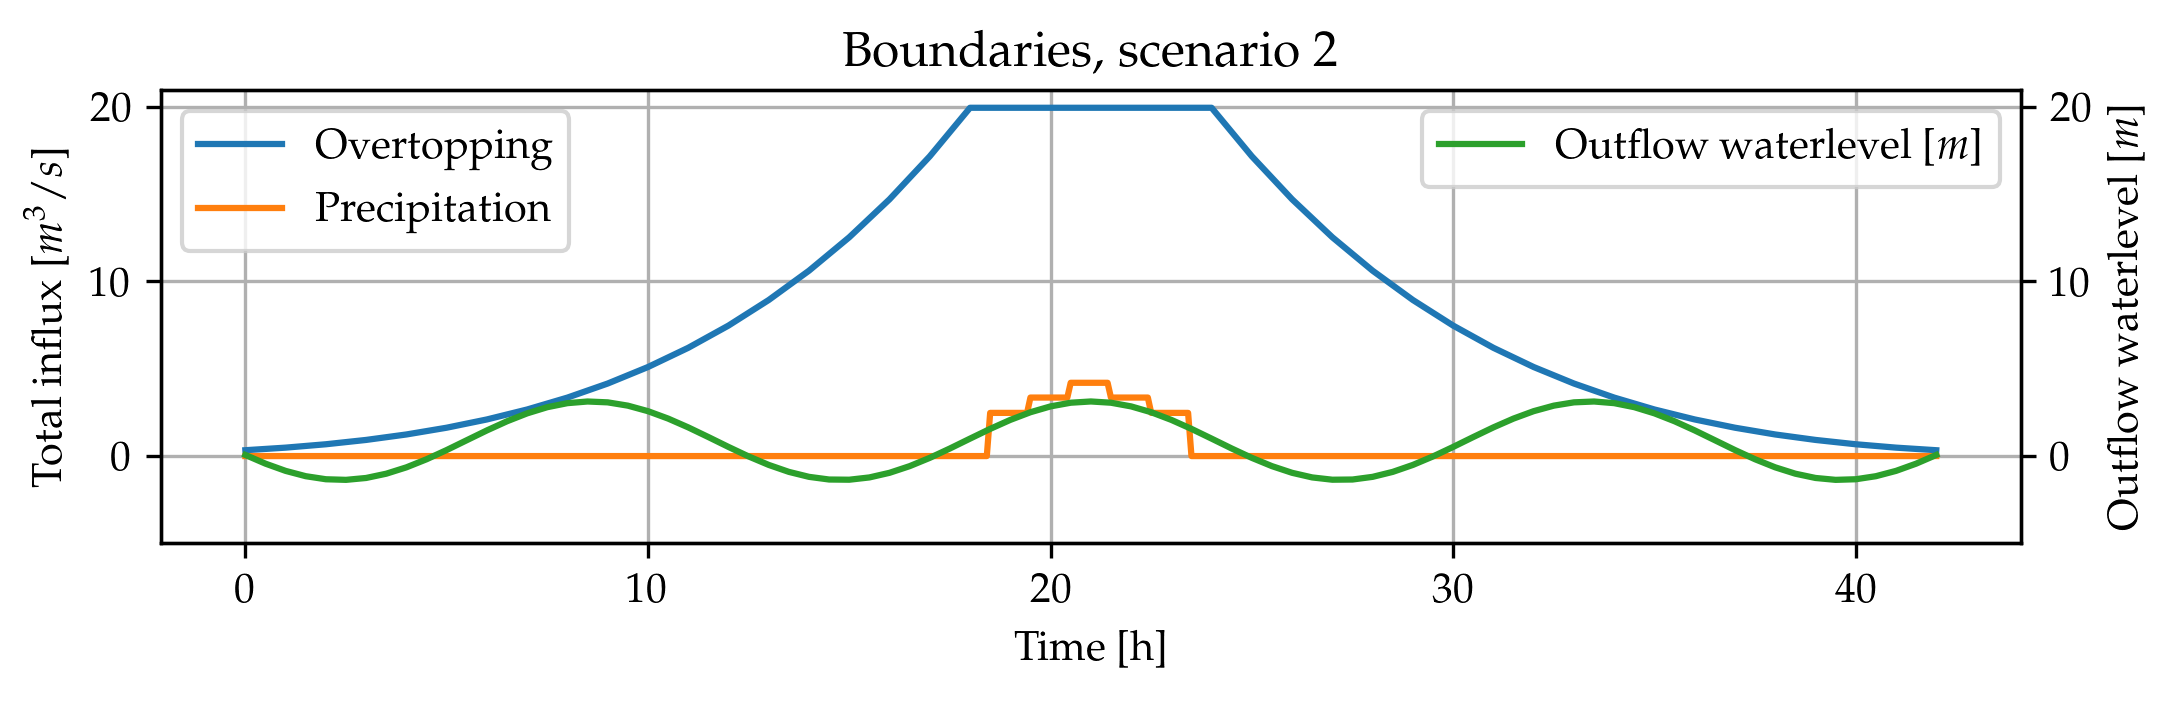

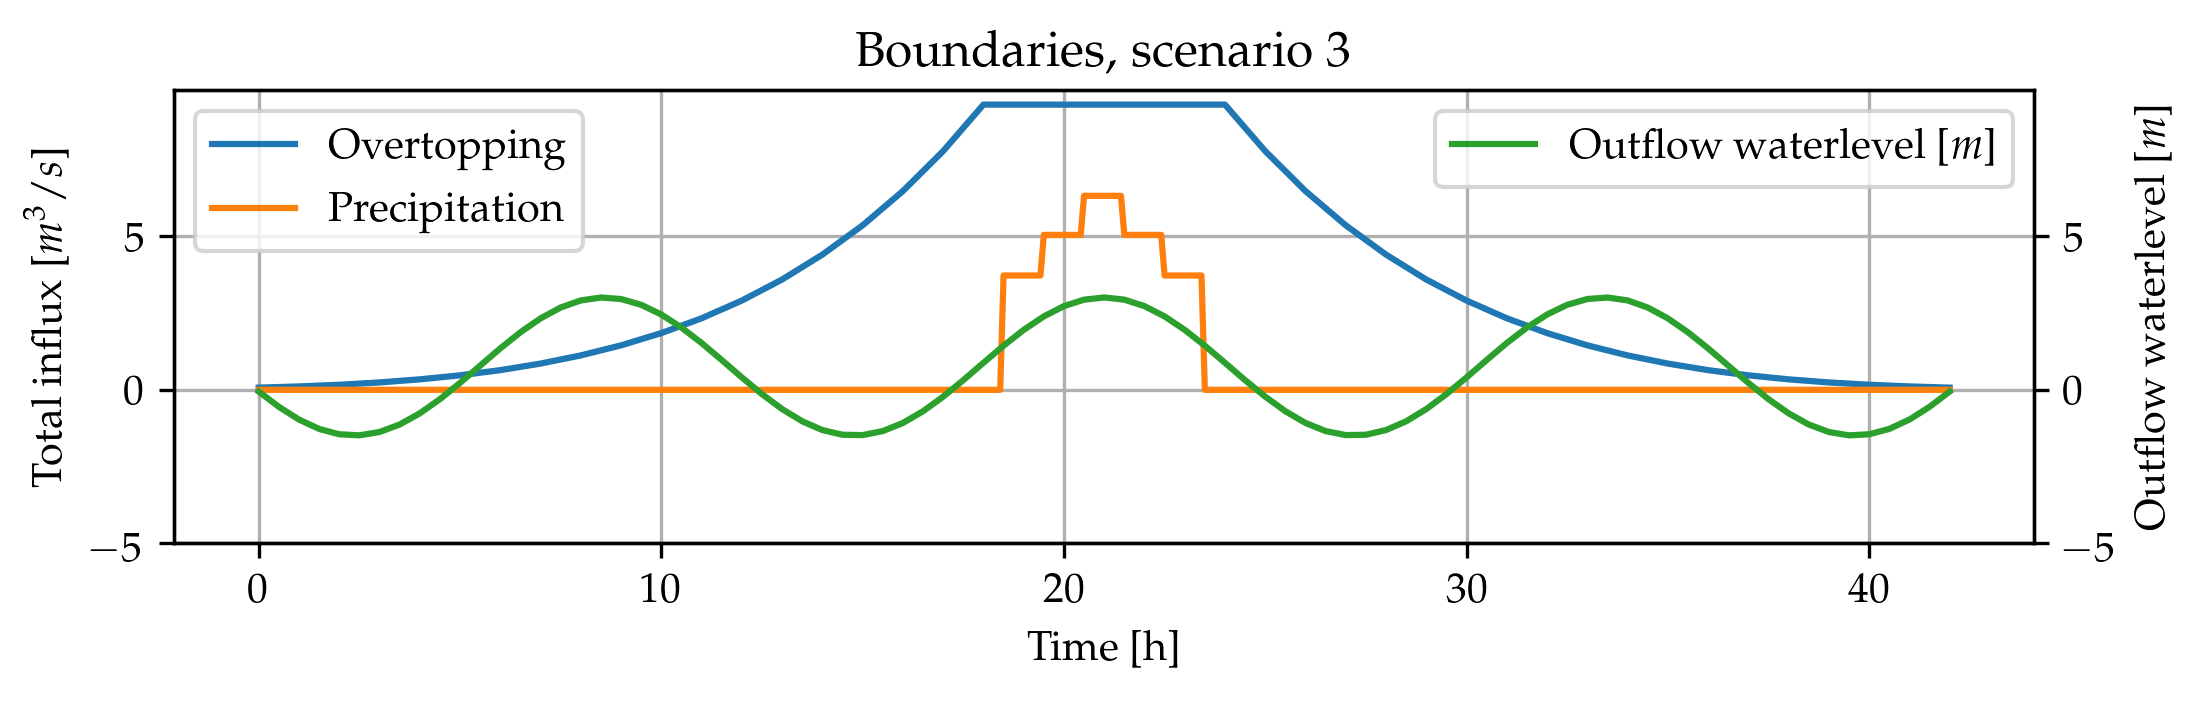

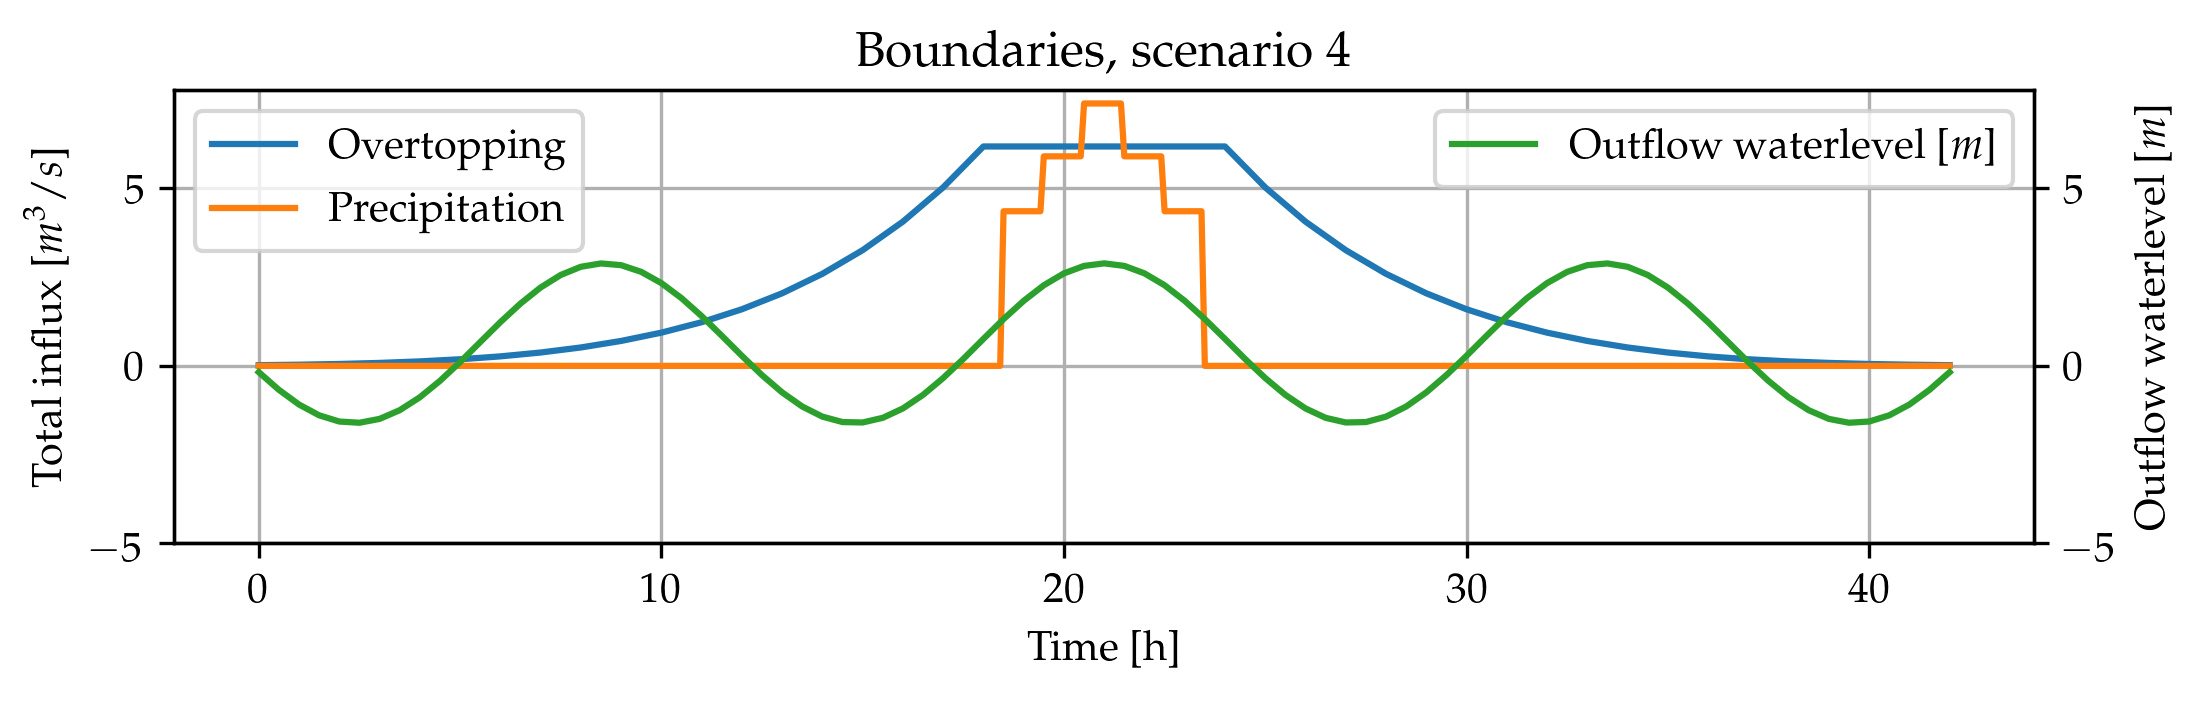

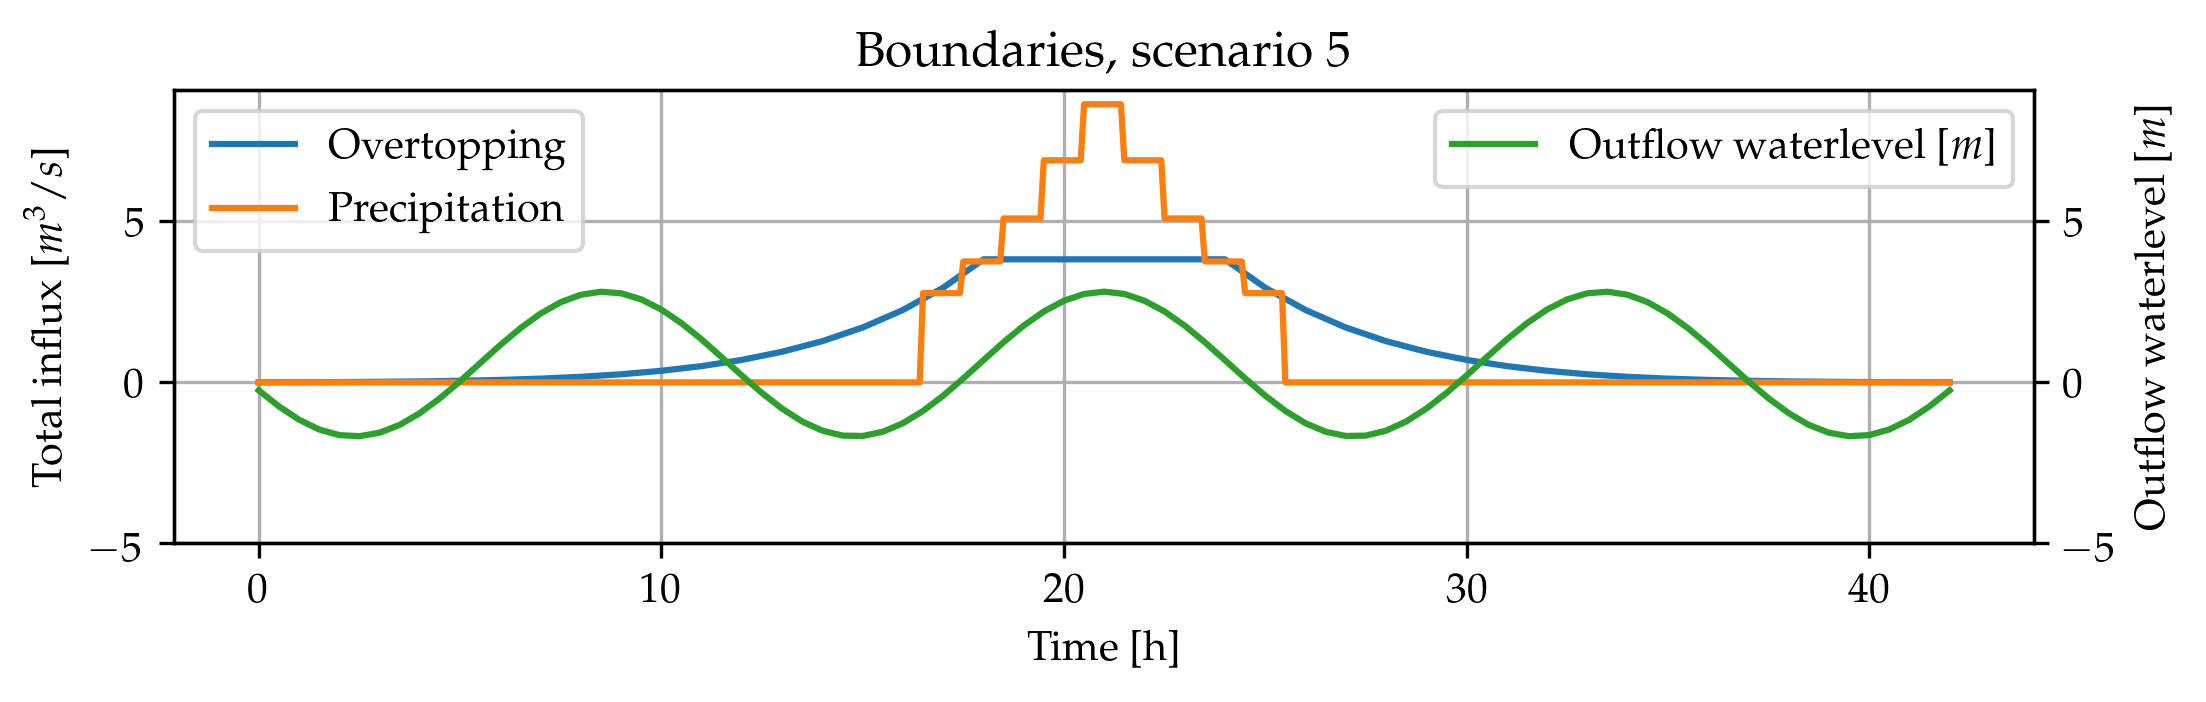

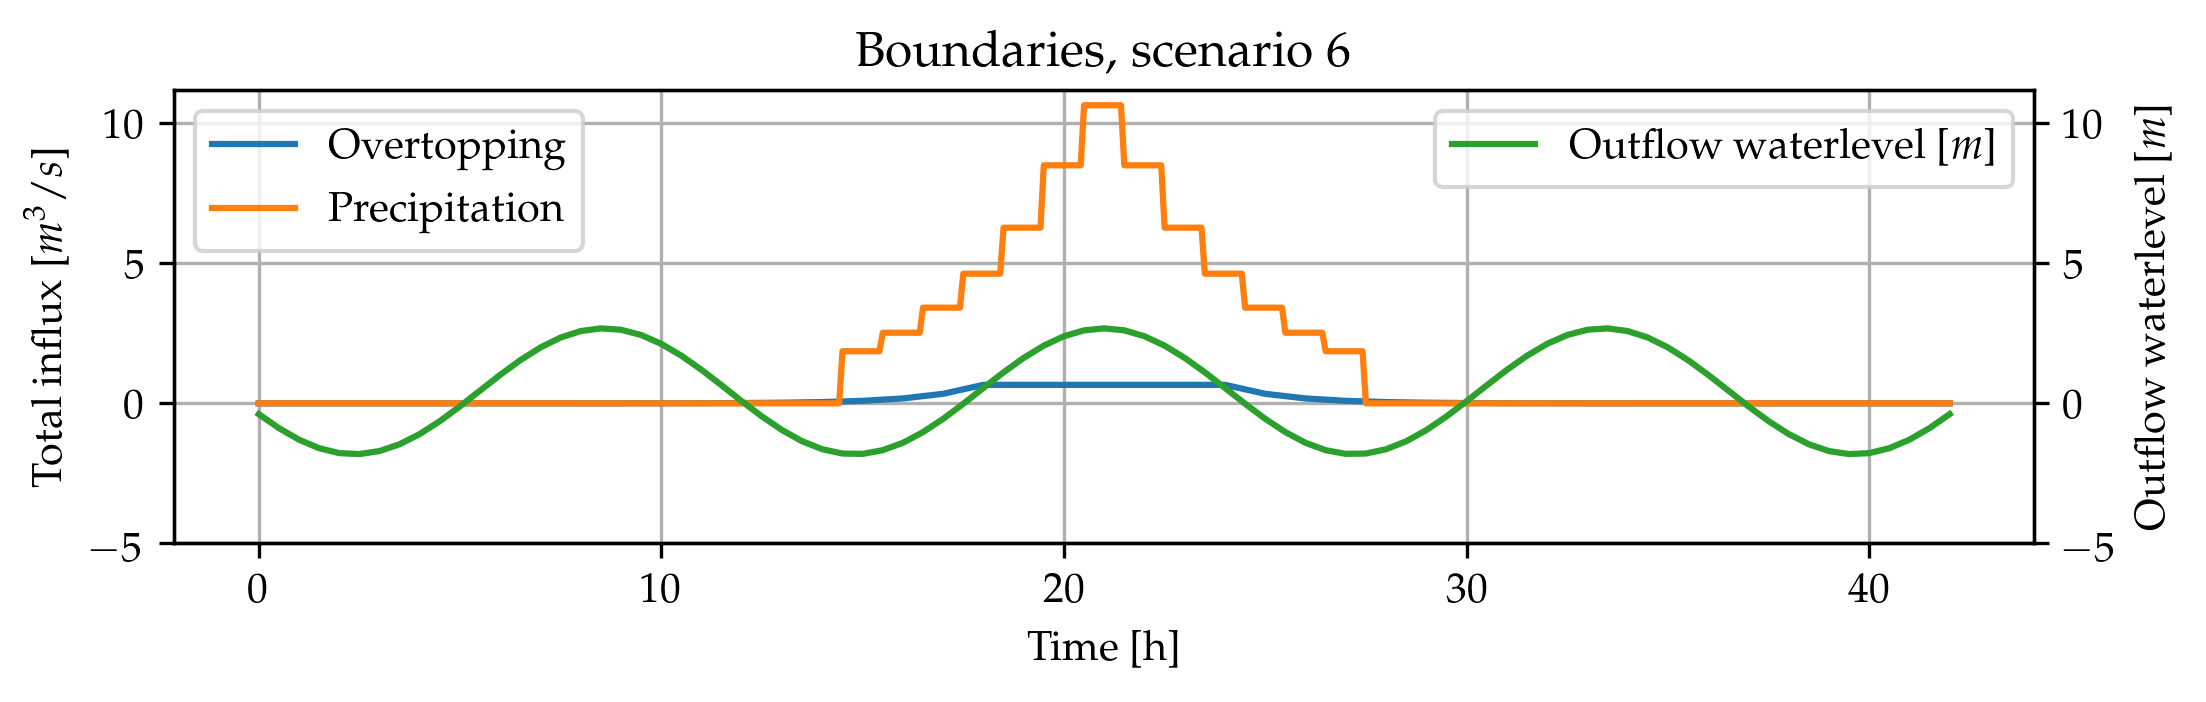

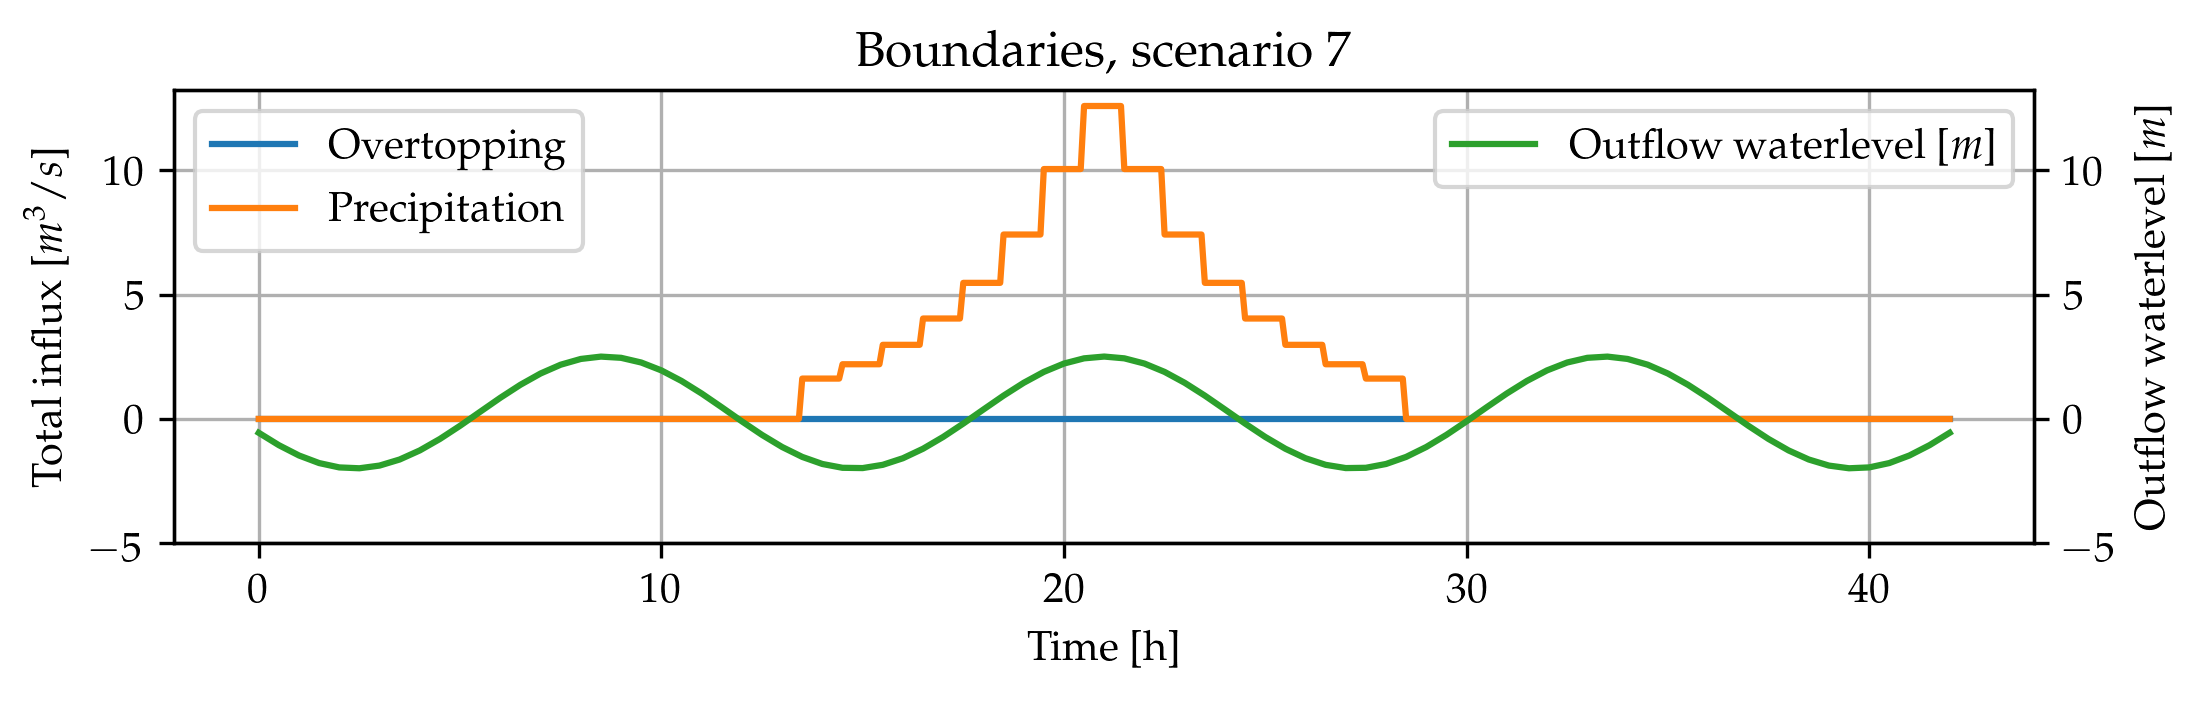

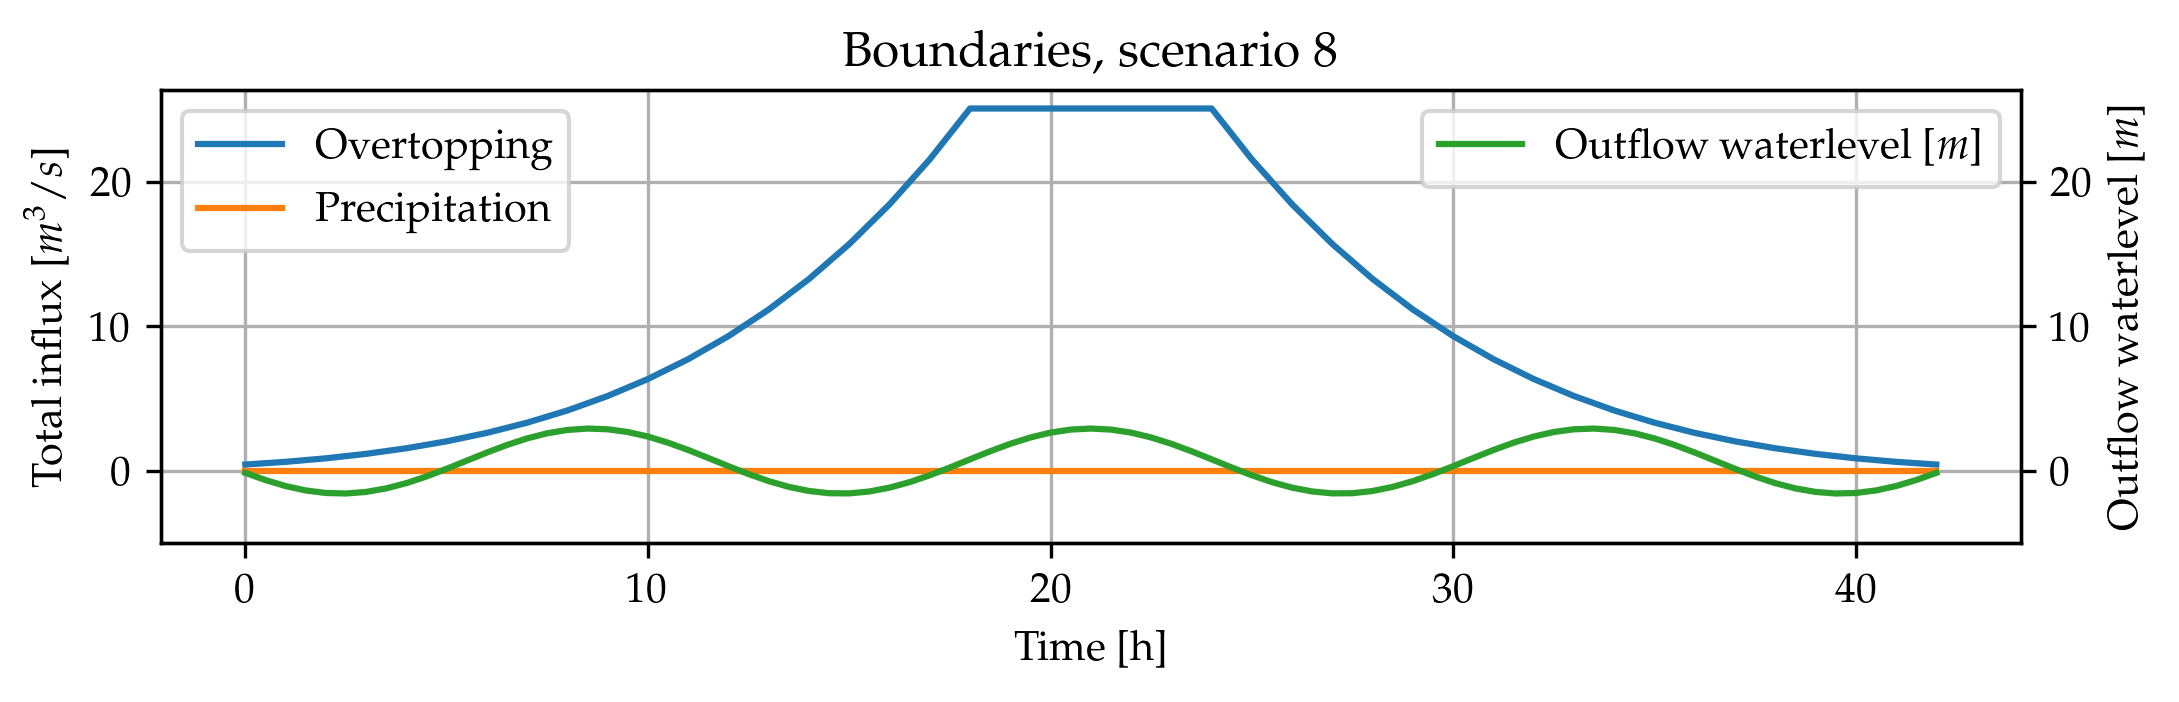

In [151]:
for Scenario in range(1,9): 
    print_output = False
    plot_output = True

    overtop_bnd_L = 1628, 209.6, 406.8, 1097.8, 775, 437.5, 227.1
    names = "loc 1_1", "loc 1_2", "Loc 2", "Loc 3", "I1","I1_2", "I2"
    path = r'C:\Users\ianmu\OneDrive - Imperial College London\Thesis\Code\Overtopping results'
    names_locs = "q_bayonet.txt", "q_emp.txt", "q_num.txt", "qmax_emp.txt"
    names_i = "q_bayonet_i.txt", "q_emp_i.txt", "q_num_i.txt"
    Q_facs = np.load('rel_Q_t.npy')
    Q_facs_extra = np.zeros([8,7,43])
    Q_facs_extra[:,0,:] = Q_facs[:,0,:]
    Q_facs_extra[:,1:5,:] = Q_facs[:,0:4,:]
    Q_facs_extra[:,5:7,:] = Q_facs[:,4:6,:]

    q_max = np.zeros([8,7])# 8 scenarios, 3[4] locs and 2[3] intermediates
    for sc in range(8):
        for loc in range(3):
            q_max[sc,loc+1] = np.max([np.loadtxt(path+"/" +names_locs[0])[sc,loc],np.loadtxt(path+"/" +names_locs[1])[sc,loc],np.loadtxt(path+"/" +names_locs[2])[sc,loc]])/1000
        for i in range(3):
            if (i>1):
                q_max[sc,i+4] = np.max([np.loadtxt(path+"/" +names_i[0])[sc,i-1],np.loadtxt(path+"/" +names_i[1])[sc,i-1],np.loadtxt(path+"/" +names_i[2])[sc,i-1]])/1000
            else:
                q_max[sc,i+4] = np.max([np.loadtxt(path+"/" +names_i[0])[sc,i],np.loadtxt(path+"/" +names_i[1])[sc,i],np.loadtxt(path+"/" +names_i[2])[sc,i]])/1000
    q_max[:,0] = q_max[:,1]
    Q = q_max*np.array(overtop_bnd_L)

    tide_a = 2.247370297323797 
    surge = 0.97, 0.88, 0.76, 0.64, 0.57, 0.43, 0.26, 0.69
    T_tide = 12+25.2/60
    t = np.linspace(0,D_coast,D_coast*2+1)
    watlev = (np.cos((t-D_coast/2)*2*np.pi/T_tide)*tide_a+surge[Scenario-1])[1:-1]
    # plt.plot(t,watlev)

    if (print_output == True):
        print('\033[1m' +"Scenario "+str(Scenario)+'\033[0m')
        print("Duration: "+str(D_coast-1)+"h")
        print()

        print('\033[1m' +"P input:"+'\033[0m')
        if (P_list[Scenario-1]!=0):
            for i in range(len(P_list[Scenario-1])):
                print(round(P_list[Scenario-1][i]/12,3))
        else:
            print(P_list[Scenario-1])

        print()
        print('\033[1m' +"Outflow input (30 min):"+'\033[0m')
        print('change this (43)')
        for i in range(len(watlev)):
            print(round(watlev[i],3))

        print()
        print('\033[1m' +"Overtopping input:"+'\033[0m')
        for j in range(len(names)):
            print(names[j])
            for i in range(len(Q_facs_extra[Scenario-1,j])):
                print(round((Q[Scenario-1,j]*Q_facs_extra[Scenario-1,j])[i],5))
            print()

    if (plot_output == True):
        fig, ax1 = plt.subplots(figsize=[8,2])
        ax2 = ax1.twinx()
        ax1.plot(np.linspace(0,42,len(Q[Scenario-1,0]*Q_facs_extra[Scenario-1,0])),sum(np.transpose(Q[Scenario-1]*np.transpose(Q_facs_extra[Scenario-1]))),label=('Overtopping'))
        if (P_list[Scenario-1]!=0):
            ax1.plot(np.linspace(0,42,len(P_list[Scenario-1])),np.array(P_list[Scenario-1])/1000/3600*Area,label='Precipitation')
        else:
            ax1.plot([0,42],[0,0],label='Precipitation')
        ax2.plot(np.linspace(0,42,len(watlev)),watlev,label='Outflow waterlevel [$m$]',color=plt.get_cmap('tab10')(2))
        max_ = np.max([np.max(np.array(P_list[Scenario-1])/1000/3600*Area),np.max(np.array(sum(np.transpose(Q[Scenario-1]*np.transpose(Q_facs_extra[Scenario-1])))))])
        ax2.set_ylim([-5,max_*1.05])
        ax1.set_ylim([-5,max_*1.05])
        plt.xlabel('time [H]')
        ax1.set_ylabel("Total influx [$m^3/s$]")
        ax2.set_ylabel("Outflow waterlevel [$m$]")
        plt.title('Boundaries, scenario '+str(Scenario))
        ax1.grid()
        ax2.legend(loc = 'upper right')
        ax1.legend(loc='upper left')
        ax1.set_xlabel("Time [h]")
    # *Q_facs_extra[Scenario-1,0]

# Inundation severity intrepetation

In [4]:
from osgeo import gdal
import rasterio 
import rasterio.plot
cover_file = "D:/Proggies/HEC-RAS/Eastbourne/Maps/Land_Cover_exp.tif"
ds = gdal.Open(cover_file)
urban = np.array(ds.GetRasterBand(1).ReadAsArray())>15

In [11]:
sc = 7
SWE = '_DWE'
time = []
for t in range(0,43):
    if (t<10):
        time.append('01JAN2021 0'+str(t)+' 00 00')
    else:
        if (t<24):
            time.append('01JAN2021 '+str(t)+' 00 00')
        else:
            if (t<34):
                time.append('02JAN2021 0'+str(t-24)+' 00 00')
            else:
                time.append('02JAN2021 '+str(t-24)+' 00 00')

t_int = np.linspace(0,42,43)
hist_list = []

h_avg = np.zeros(len(t_int))
files = []
for t in range(len(time)):
    if (SWE != None):
        if (t == 0):
            print(SWE+" is active")
        files.append(r'D:\Proggies\HEC-RAS\Eastbourne\sc'+str(sc)+SWE+'\Depth ('+time[t]+').vrt')
    else:
        if (sc==1 or sc==7):
            files.append(r'D:\Proggies\HEC-RAS\Eastbourne\sc'+str(sc)+'_2\Depth ('+time[t]+').vrt')
        else:
            files.append(r'D:\Proggies\HEC-RAS\Eastbourne\sc'+str(sc)+'\Depth ('+time[t]+').vrt')
    
vrt_options = gdal.BuildVRTOptions()
with rasterio.open(r'D:\Proggies\HEC-RAS\Eastbourne\sc1_2\Depth (01JAN2021 00 00 00).vrt') as raster_vrt:
#         rasterio.plot.show(raster_vrt)
    data  = raster_vrt.read()
river = (data[0]!=-9999)[:]
not_river = np.ones((len(river),len(river[0])))
not_river[river==1] = np.nan

labels = time
cmap = plt.get_cmap("Blues",len(files)+1)

plt.figure(figsize=[8,3])
for i in range(0,len(files)):
    vrt_options = gdal.BuildVRTOptions()
    with rasterio.open(files[i]) as raster_vrt:
#         rasterio.plot.show(raster_vrt)
        data  = raster_vrt.read()
    data[data==-9999] = np.nan
    data *= (urban*not_river)
    data = data.flatten()
    
    Area = 321112*16.06

    hist = np.histogram(data[~np.isnan(data)],100,range=[0,3])
    hist_list.append(hist)
    h_avg[i] = np.nansum(data)/Area

_DWE is active


<Figure size 2400x900 with 0 Axes>

28


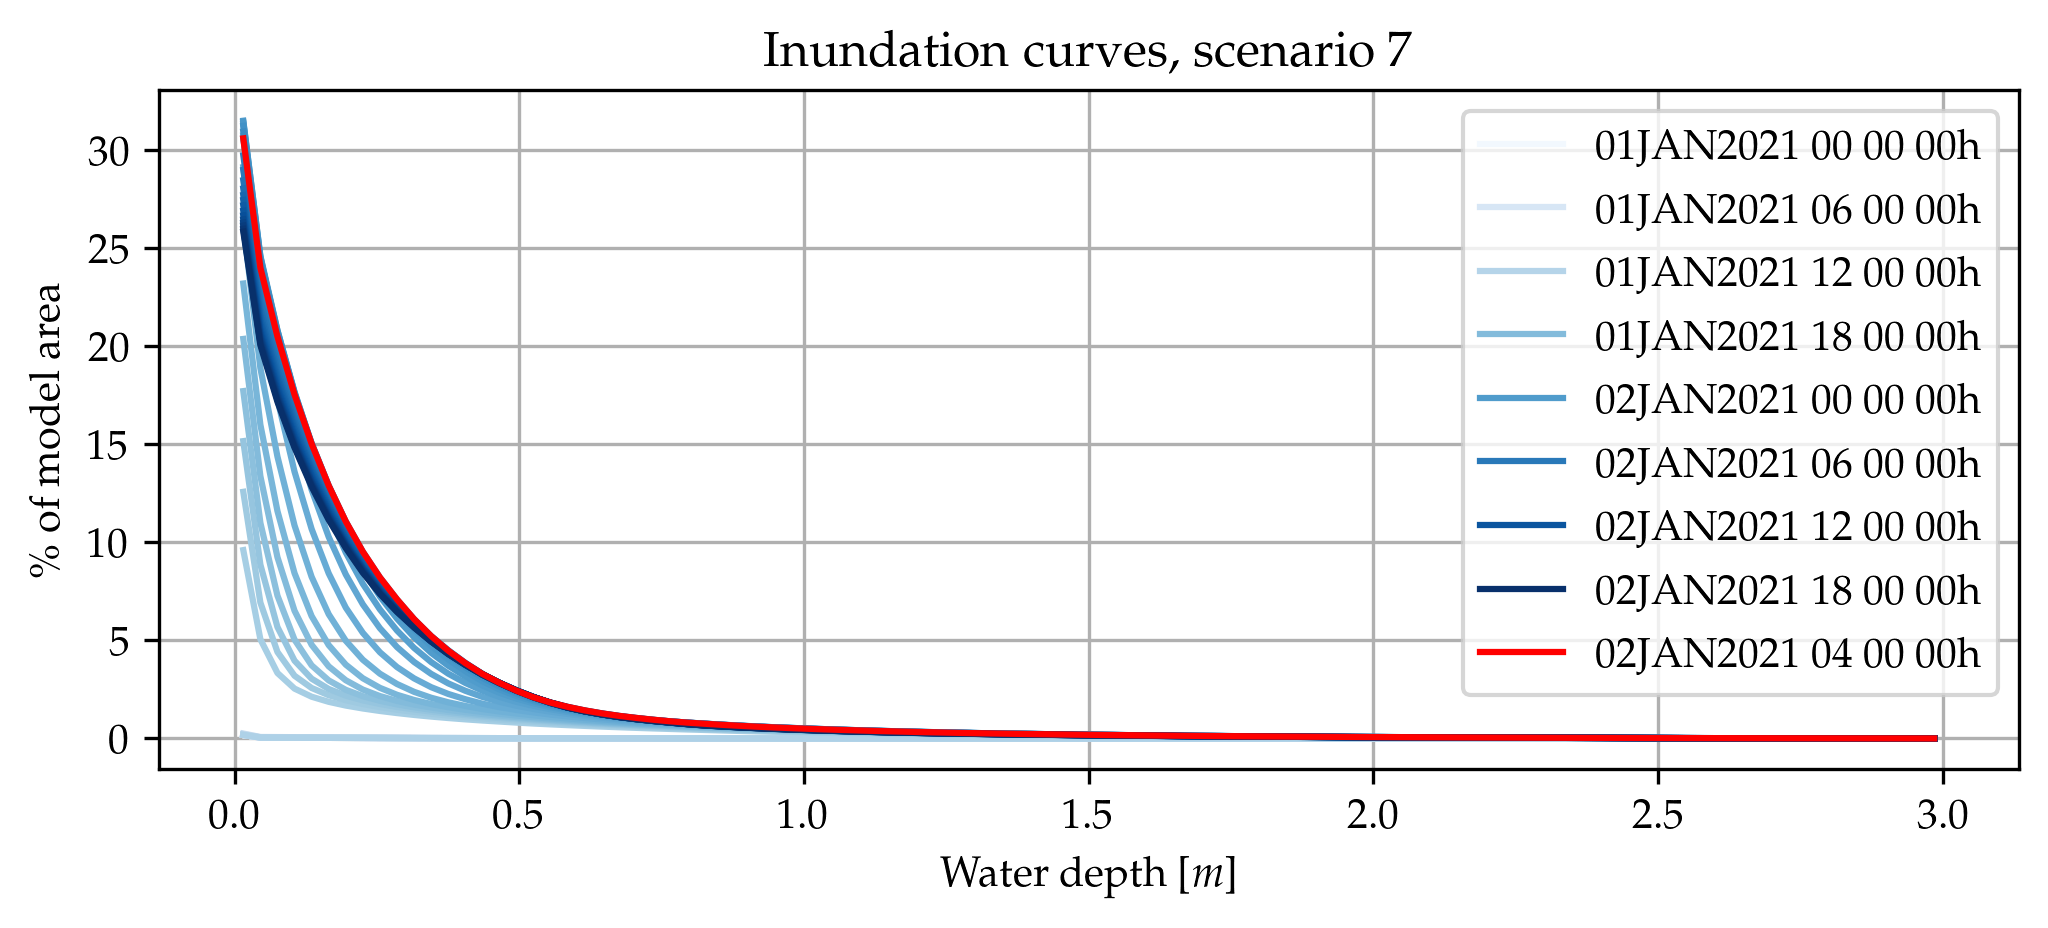

In [12]:
plt.figure(figsize=[8,3])
max_V = 0
for i in range(len(hist_list)):
    if(i/6 - int(i/6)==0):
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist_list[i][0]/Area*100))),label=str(labels[i])+'h',color=cmap(i+1))
    else:
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist_list[i][0]/Area*100))),color=cmap(i+1))
    if (np.sum(hist_list[i][0]/Area*np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1))>max_V):
        max_V = np.sum(hist_list[i][0]/Area*np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1))
        i_max = i
plt.grid()
plt.xlabel("Water depth [$m$]")
plt.ylabel('\% of model area')
plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist_list[i_max][0]/Area*100))),label=str(labels[i_max])+'h',color='r')
plt.legend()
if (SWE=="_SWE"):
    plt.title('Inundation curves, SWE, scenario '+str(sc))
else:
    plt.title('Inundation curves, scenario '+str(sc))
print(i_max)

_SWE is active
sc2, i_max:29
_SWE is active


C:\Users\ianmu\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


sc3, i_max:24
_SWE is active


C:\Users\ianmu\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


sc4, i_max:24
_SWE is active


C:\Users\ianmu\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


sc5, i_max:25
_SWE is active


C:\Users\ianmu\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


sc6, i_max:27
_SWE is active


C:\Users\ianmu\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


sc7, i_max:27


C:\Users\ianmu\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 2400x900 with 0 Axes>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


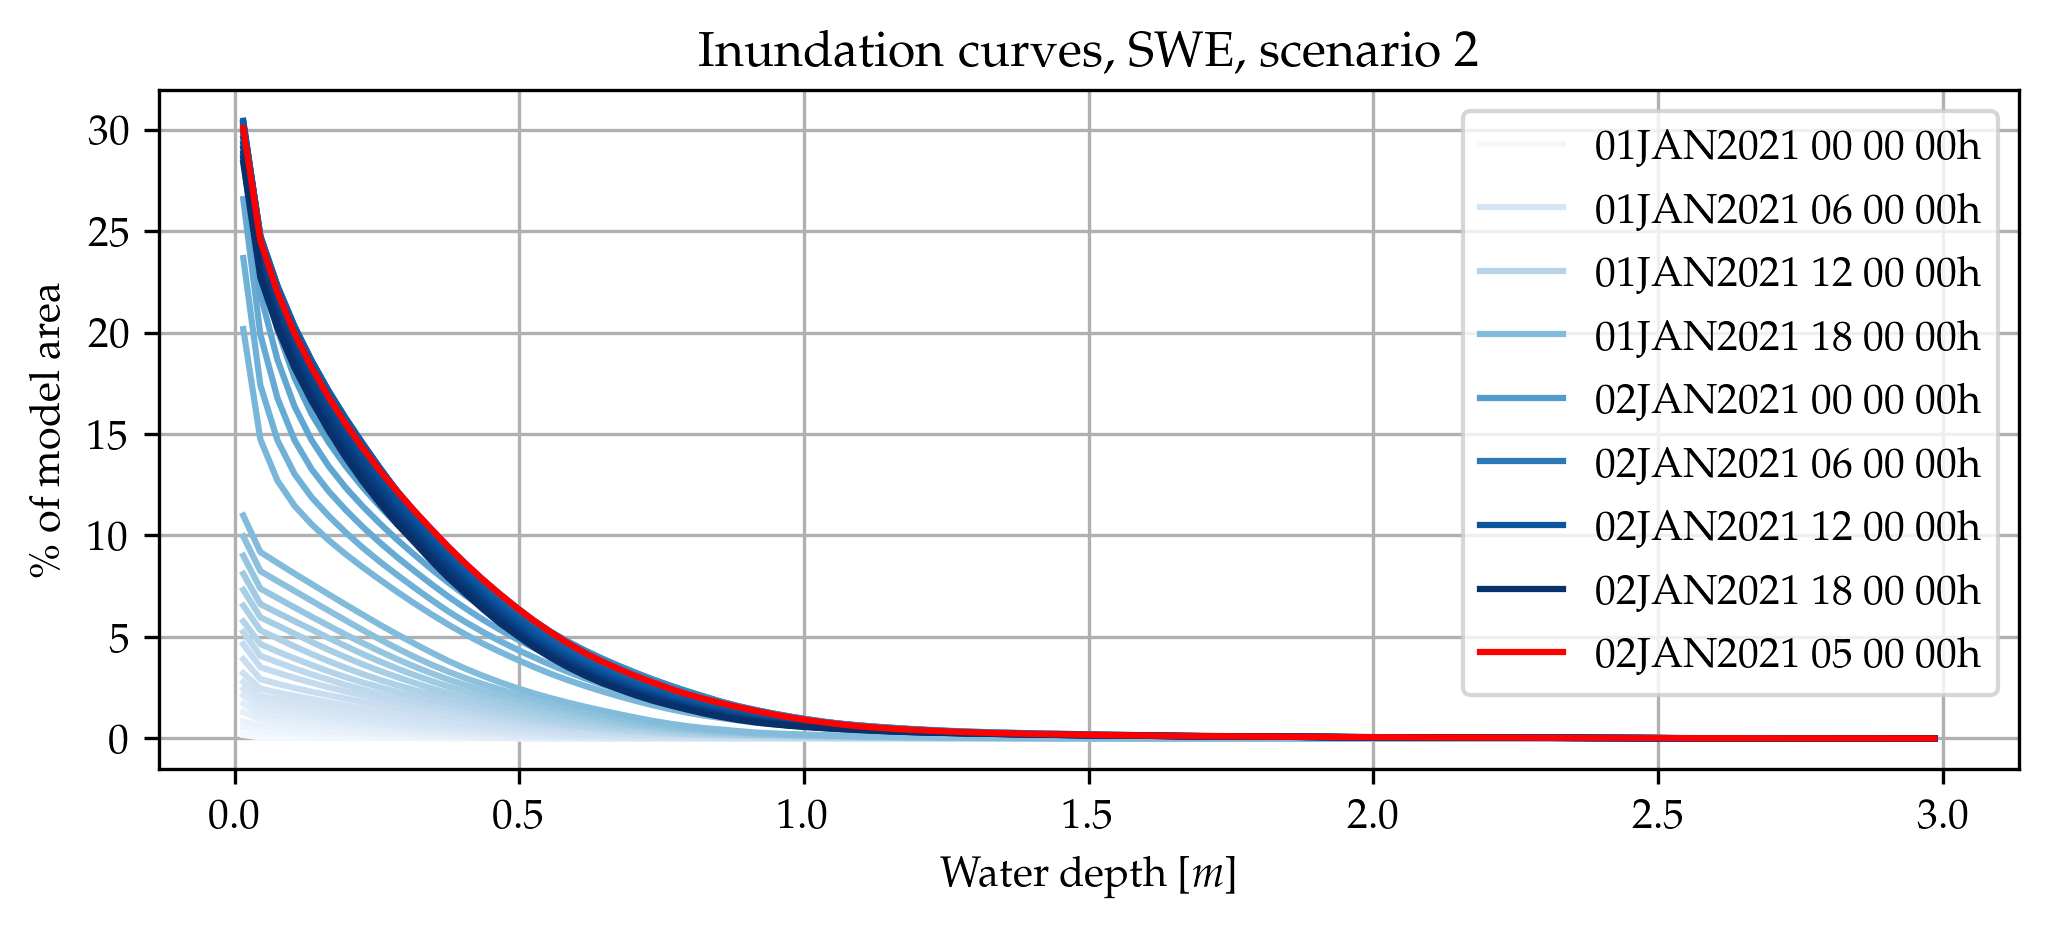

<Figure size 2400x900 with 0 Axes>

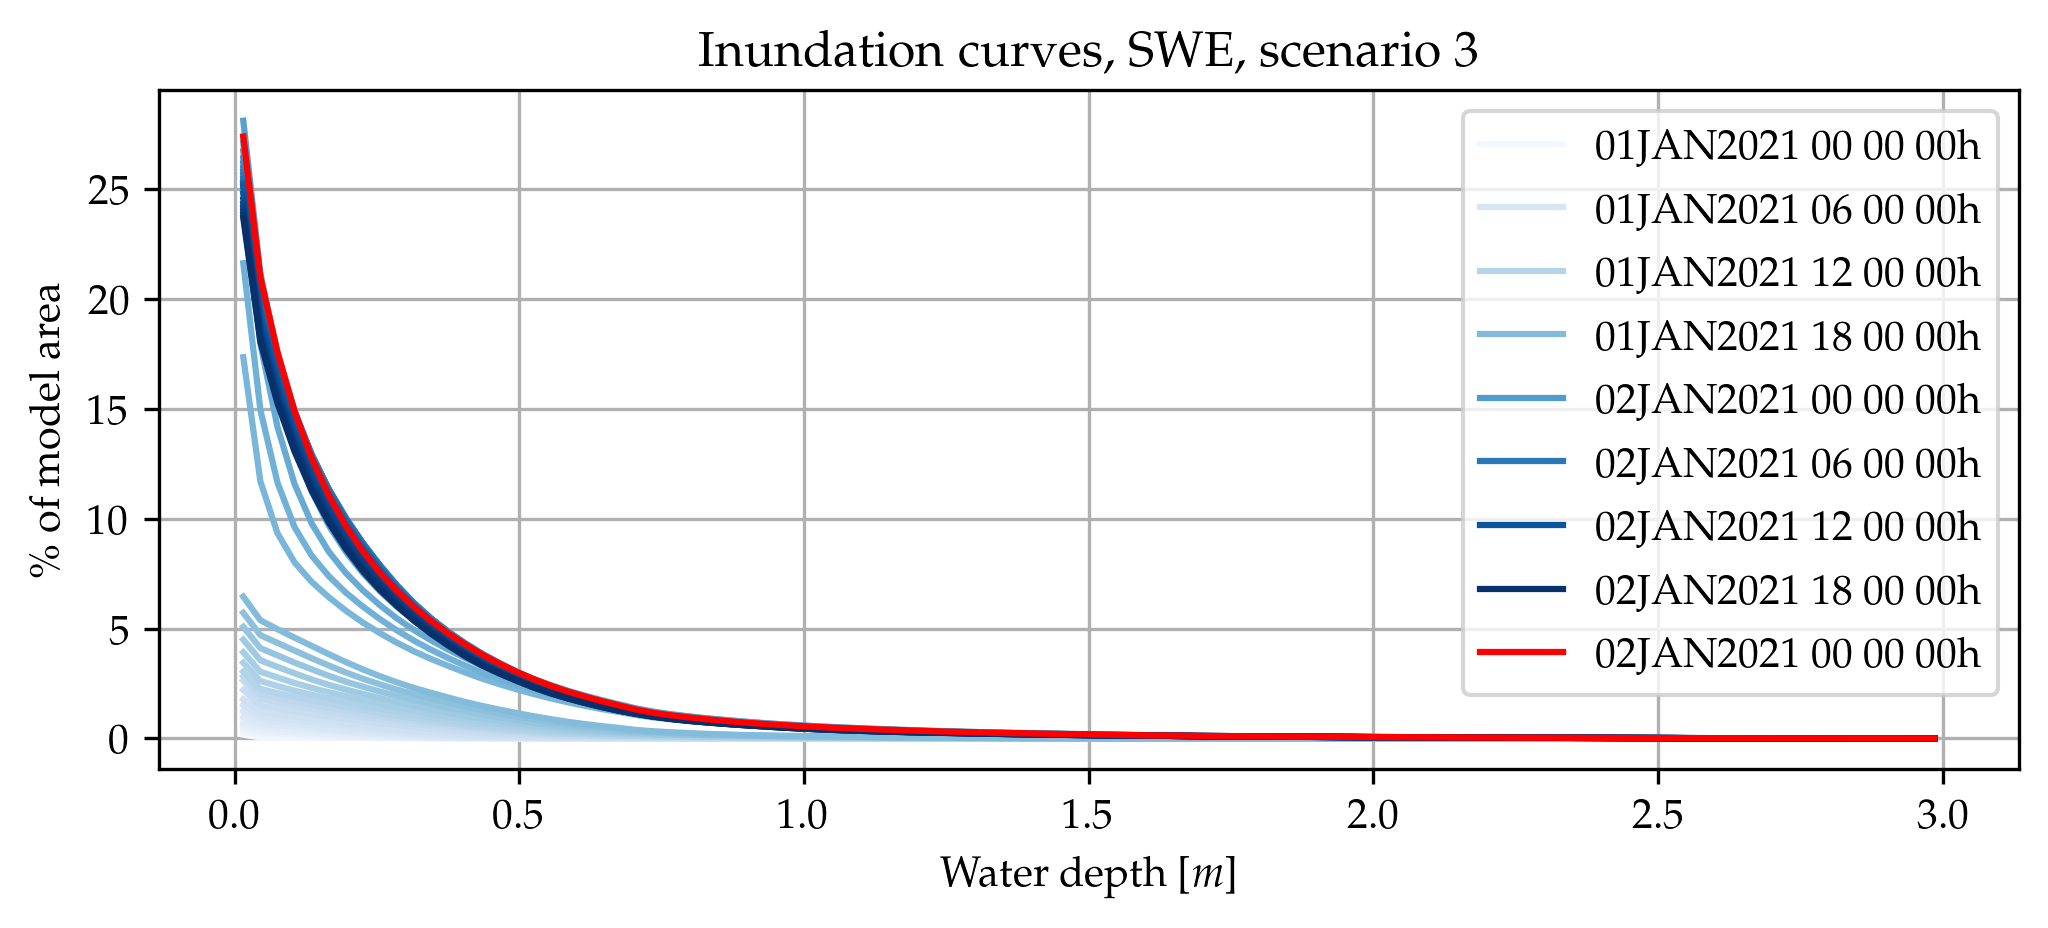

<Figure size 2400x900 with 0 Axes>

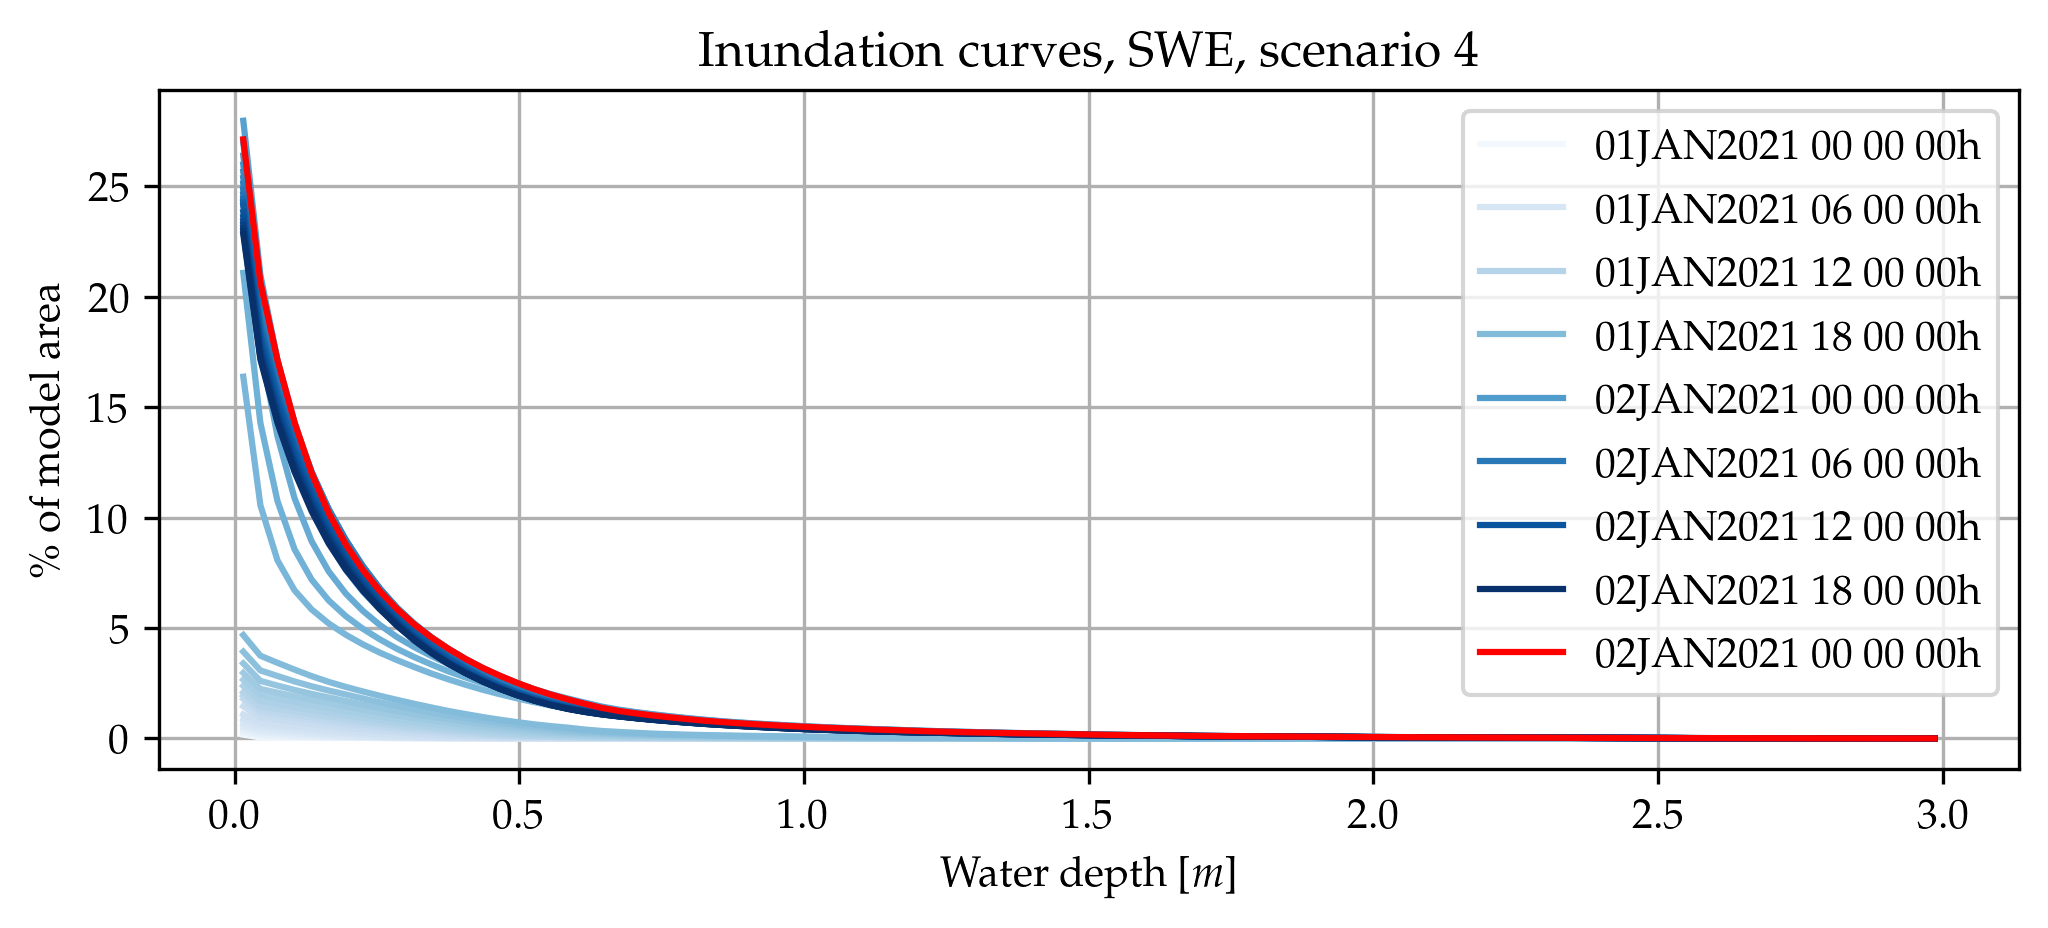

<Figure size 2400x900 with 0 Axes>

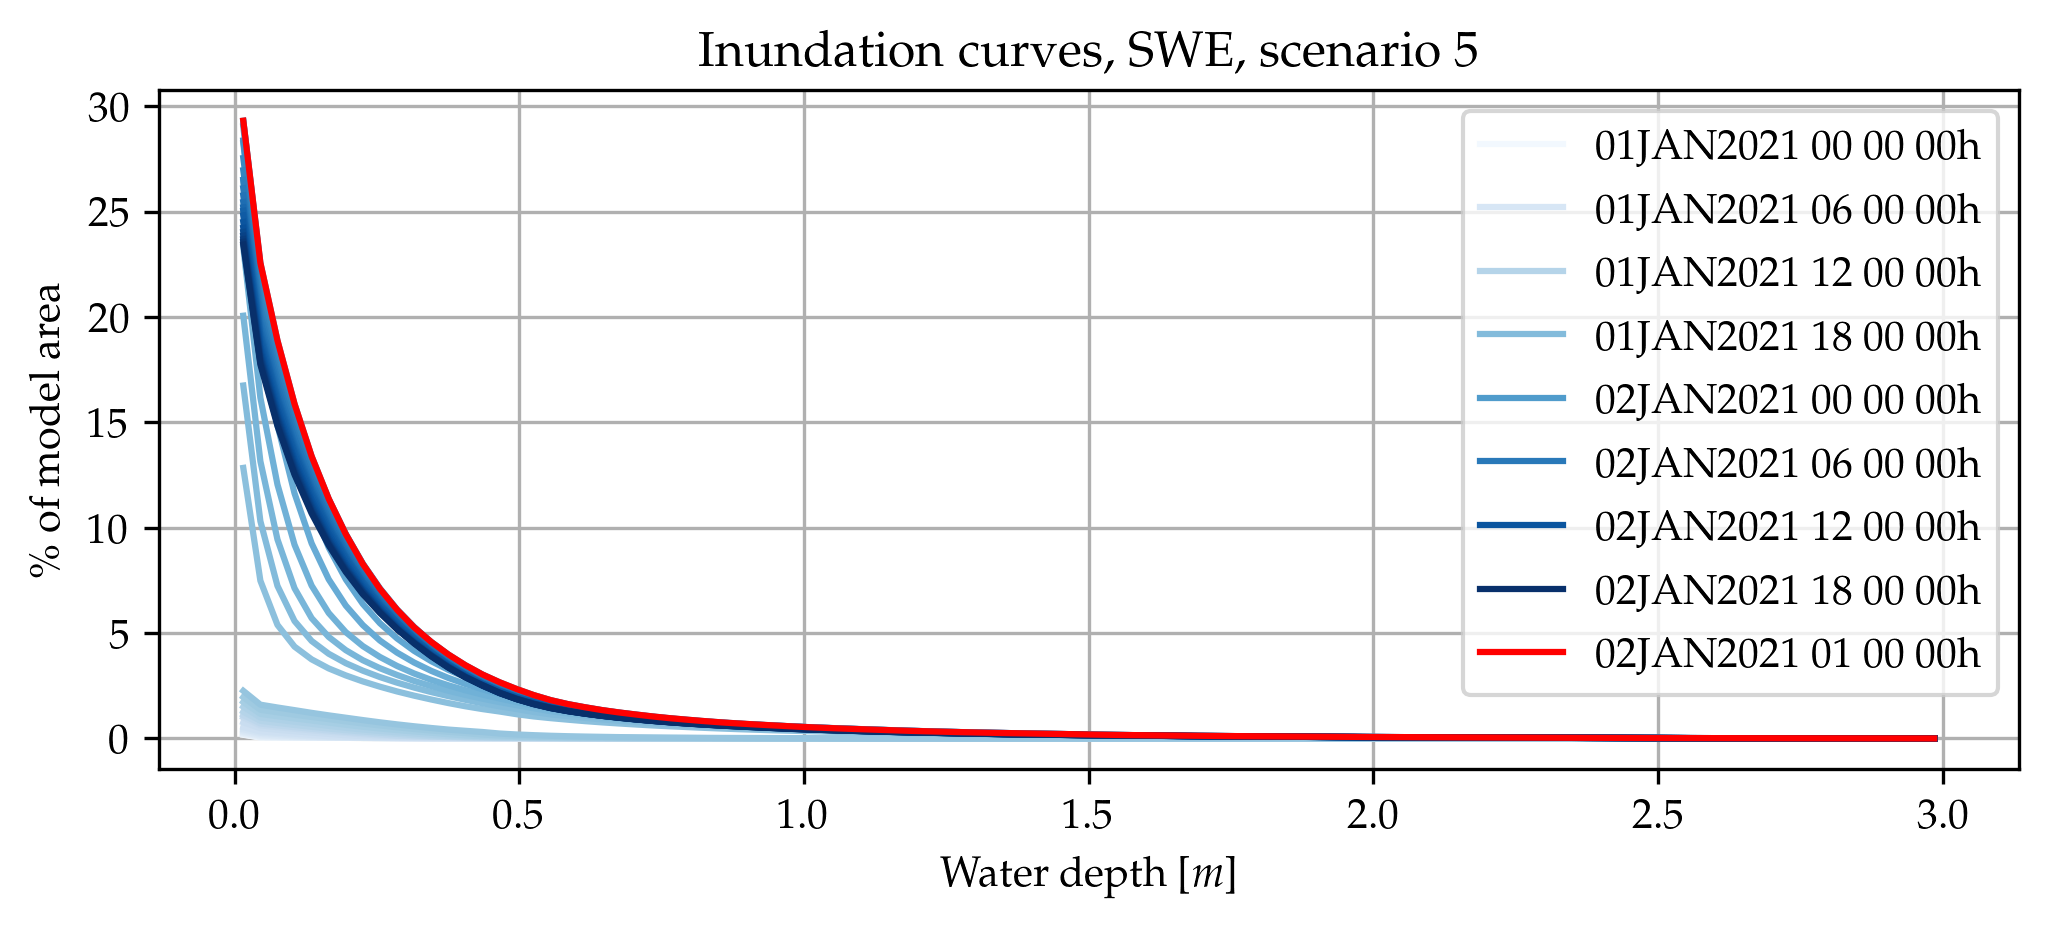

<Figure size 2400x900 with 0 Axes>

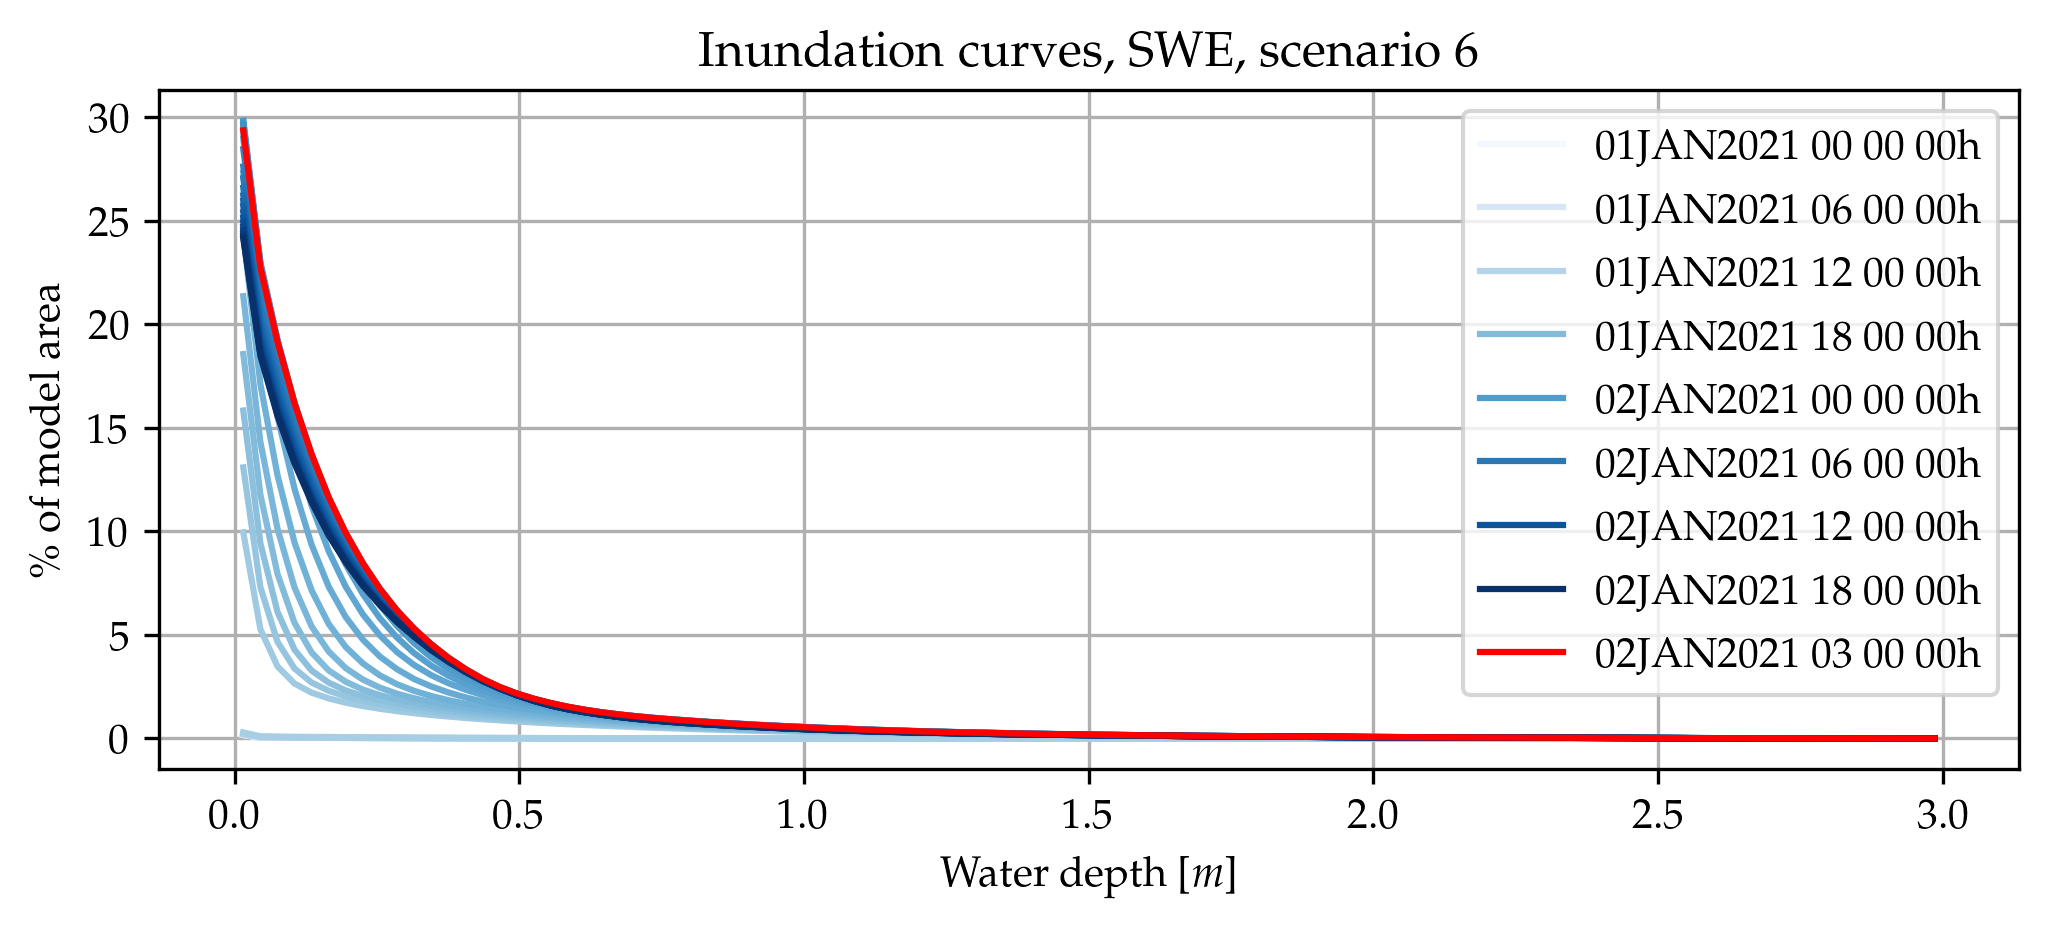

<Figure size 2400x900 with 0 Axes>

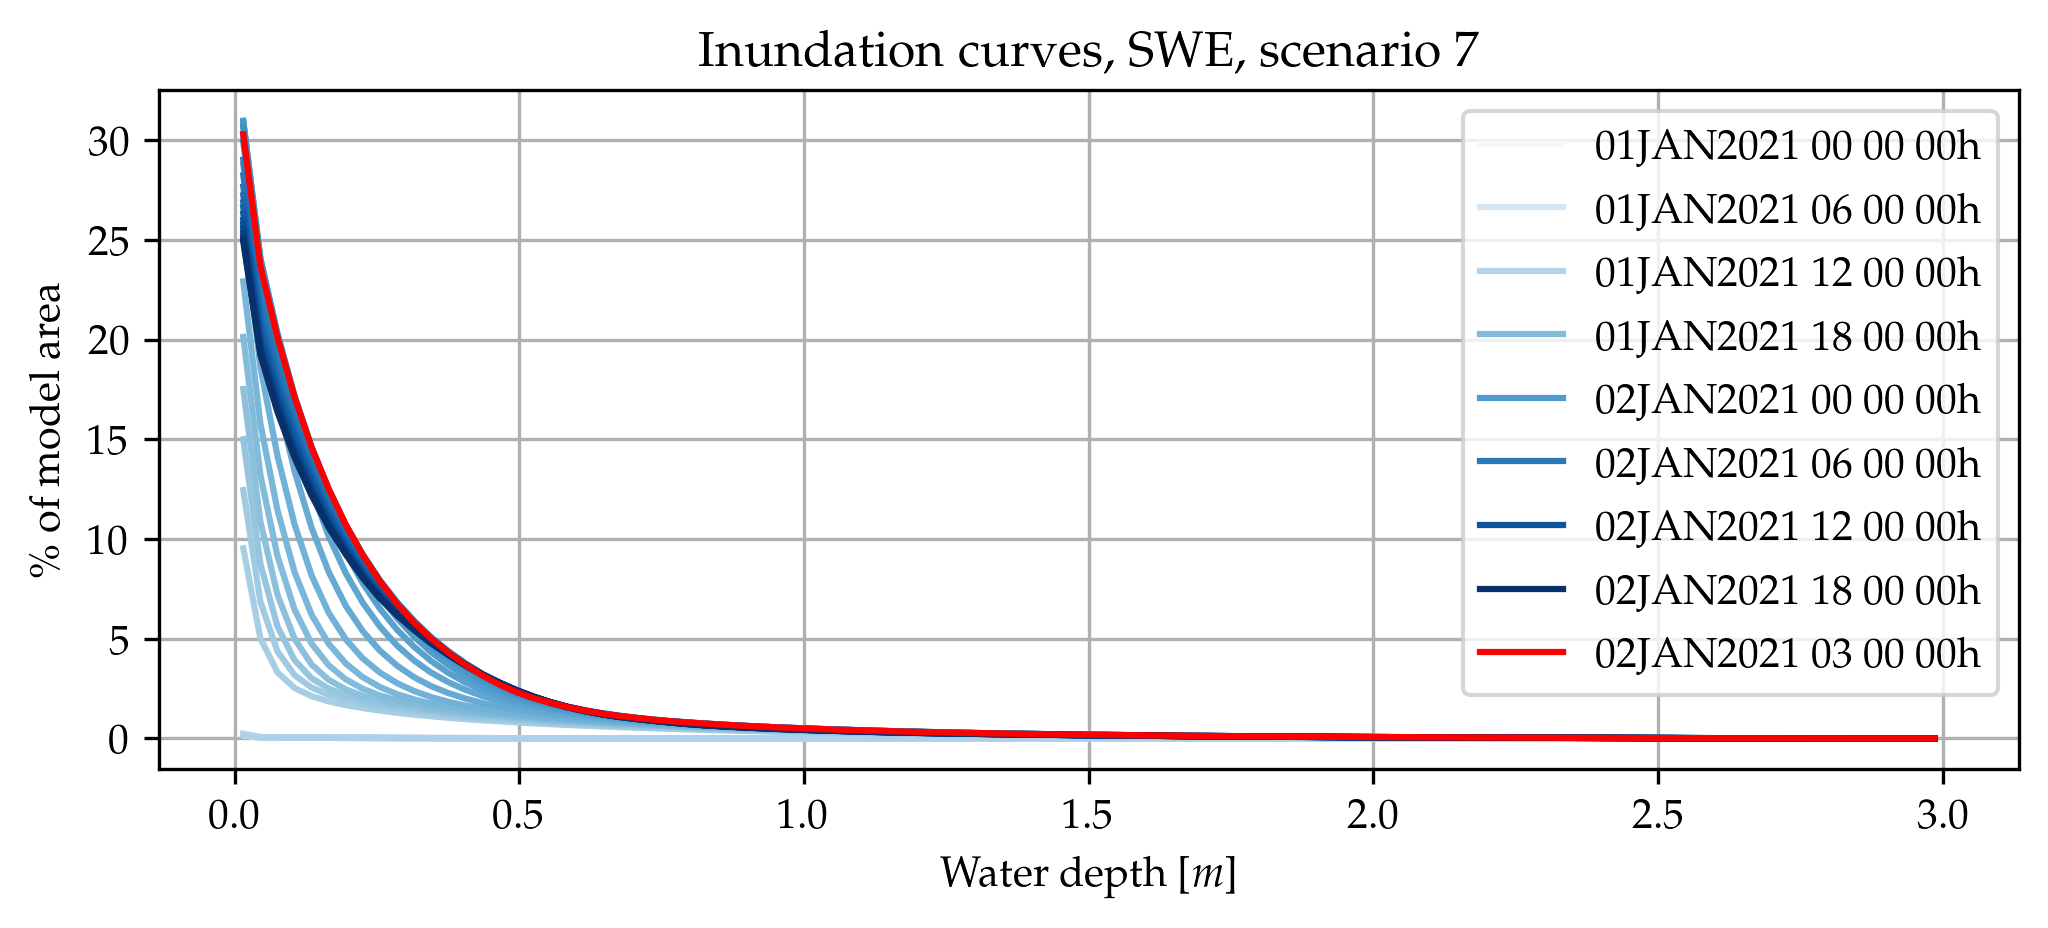

In [4]:
# Looped for all scenarios

for sc in range(2,8):
    SWE = '_SWE'
    time = []
    for t in range(0,43):
        if (t<10):
            time.append('01JAN2021 0'+str(t)+' 00 00')
        else:
            if (t<24):
                time.append('01JAN2021 '+str(t)+' 00 00')
            else:
                if (t<34):
                    time.append('02JAN2021 0'+str(t-24)+' 00 00')
                else:
                    time.append('02JAN2021 '+str(t-24)+' 00 00')

    t_int = np.linspace(0,42,43)
    hist_list = []

    h_avg = np.zeros(len(t_int))
    files = []
    for t in range(len(time)):
        if (SWE != None):
            if (t == 0):
                print(SWE+" is active")
            files.append(r'D:\Proggies\HEC-RAS\Eastbourne\sc'+str(sc)+SWE+'\Depth ('+time[t]+').vrt')
        else:
            if (sc==1 or sc==7):
                files.append(r'D:\Proggies\HEC-RAS\Eastbourne\sc'+str(sc)+'_2\Depth ('+time[t]+').vrt')
            else:
                files.append(r'D:\Proggies\HEC-RAS\Eastbourne\sc'+str(sc)+'\Depth ('+time[t]+').vrt')

    vrt_options = gdal.BuildVRTOptions()
    with rasterio.open(r'D:\Proggies\HEC-RAS\Eastbourne\sc1_2\Depth (01JAN2021 00 00 00).vrt') as raster_vrt:
    #         rasterio.plot.show(raster_vrt)
        data  = raster_vrt.read()
    river = (data[0]!=-9999)[:]
    not_river = np.ones((len(river),len(river[0])))
    not_river[river==1] = np.nan

    labels = time
    cmap = plt.get_cmap("Blues",len(files)+1)

    plt.figure(figsize=[8,3])
    for i in range(0,len(files)):
        vrt_options = gdal.BuildVRTOptions()
        with rasterio.open(files[i]) as raster_vrt:
    #         rasterio.plot.show(raster_vrt)
            data  = raster_vrt.read()
        data[data==-9999] = np.nan
        data *= (urban*not_river)
        data = data.flatten()

        Area = 321112*16.06

        hist = np.histogram(data[~np.isnan(data)],100,range=[0,3])
        hist_list.append(hist)
        h_avg[i] = np.nansum(data)/Area

    ### plot
    plt.figure(figsize=[8,3])
    max_V = 0
    for i in range(len(hist_list)):
        if(i/6 - int(i/6)==0):
            plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist_list[i][0]/Area*100))),label=str(labels[i])+'h',color=cmap(i+1))
        else:
            plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist_list[i][0]/Area*100))),color=cmap(i+1))
        if (np.sum(hist_list[i][0]/Area*np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1))>max_V):
            max_V = np.sum(hist_list[i][0]/Area*np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1))
            i_max = i
    plt.grid()
    plt.xlabel("Water depth [$m$]")
    plt.ylabel('\% of model area')
    plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist_list[i_max][0]/Area*100))),label=str(labels[i_max])+'h',color='r')
    plt.legend()
    if (SWE=="_SWE"):
        plt.title('Inundation curves, SWE, scenario '+str(sc))
    else:
        plt.title('Inundation curves, scenario '+str(sc))
    print("sc"+str(sc)+", i_max:"+str(i_max))
    
    ### Saving
    if (SWE != None):
        np.save("Hist_"+str(sc)+SWE,hist_list[i_max])
    else:
        np.save("Hist_"+str(sc),hist_list[i_max])

In [14]:
#               1  2  3  4  5  6  7  8
# t_maxes =     29,24,25,24,25,27,28,29
# t_maxes_SWE = 28,29,24,24,25,26,27,28
# LOW_RES_DWE =                   28

# Saving
if (SWE != None):
    np.save("Hist_"+str(sc)+SWE,hist_list[i_max])
else:
    np.save("Hist_"+str(sc),hist_list[i_max])

C:\Users\ianmu\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


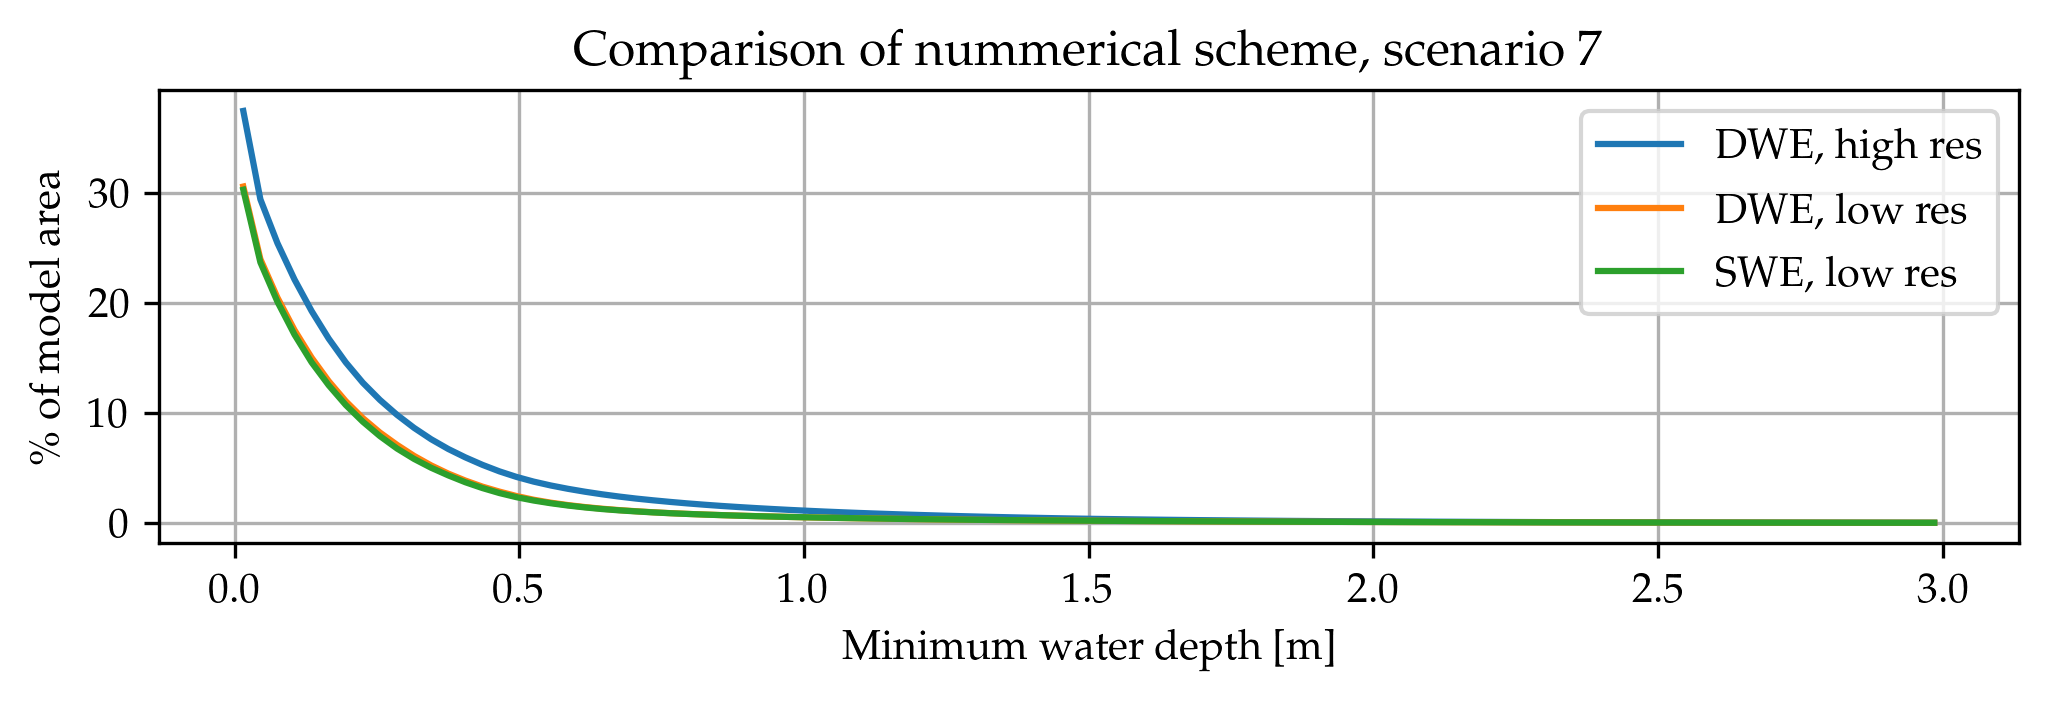

In [15]:
sc = 7
Area = 321112*16.06

plt.figure(figsize=[8,2])
plt.grid()
plt.xlabel("Minimum water depth [m]")
plt.ylabel('\% of model area')
# plt.ylim(0,2)

hist = np.load("Hist_"+str(sc)+".npy",allow_pickle=True)
hist_SWE = np.load("Hist_"+str(sc)+"_SWE.npy",allow_pickle=True)
hist_DWE = np.load("Hist_"+str(sc)+"_DWE.npy",allow_pickle=True)

plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist[0]/Area*100))),label = "DWE, high res")
plt.plot(np.linspace(np.mean(hist_DWE[1][0:2]),np.mean(hist_DWE[1][-2:]),len(hist_DWE[1])-1),np.flip(np.cumsum(np.flip(hist_DWE[0]/Area*100))),label = "DWE, low res")
plt.plot(np.linspace(np.mean(hist_SWE[1][0:2]),np.mean(hist_SWE[1][-2:]),len(hist_SWE[1])-1),np.flip(np.cumsum(np.flip(hist_SWE[0]/Area*100))),label="SWE, low res")
plt.title("Comparison of nummerical scheme, scenario "+str(sc))
plt.legend()

Text(0.5, 1.0, 'Inundation curves, Diffusive wave approximation')

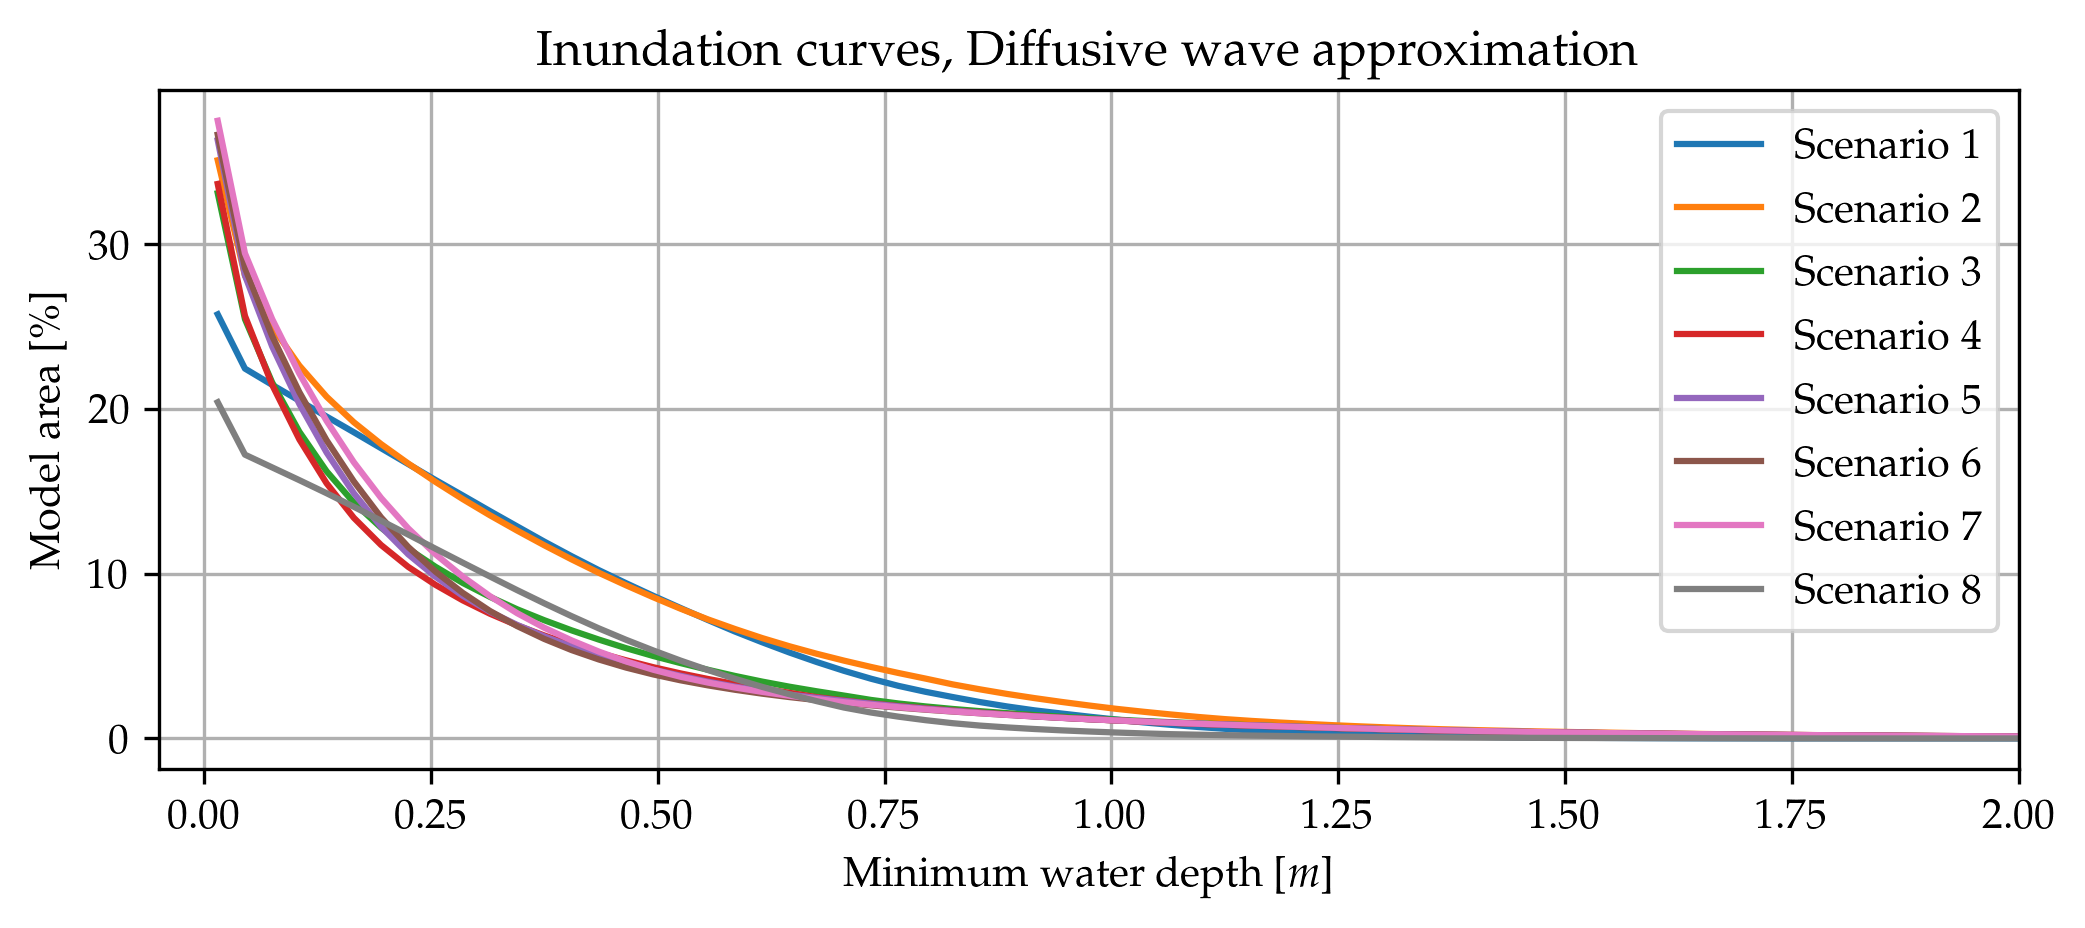

In [7]:
# cmap = plt.get_cmap("viridis",8)
Area = 321112*16.06
SWE = None

plt.figure(figsize=[8,3])
for sc in range(1,9):
    if (SWE == "_SWE"):
        hist = np.load("Hist_"+str(sc)+SWE+".npy",allow_pickle=True)
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist[0]/Area*100))),label='Scenario '+str(sc))
    else:
        hist = np.load("Hist_"+str(sc)+".npy",allow_pickle=True)
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist[0]/Area*100))),label='Scenario '+str(sc))
plt.grid()
plt.xlim(-0.05,2)
plt.xlabel("Minimum water depth [$m$]")
plt.ylabel('Model area [\%]')
plt.legend()
plt.title('Inundation curves, Diffusive wave approximation')

# hist[0]/Area*100

Text(0.5, 1.0, 'Inundation curves, DWE \\& SWE')

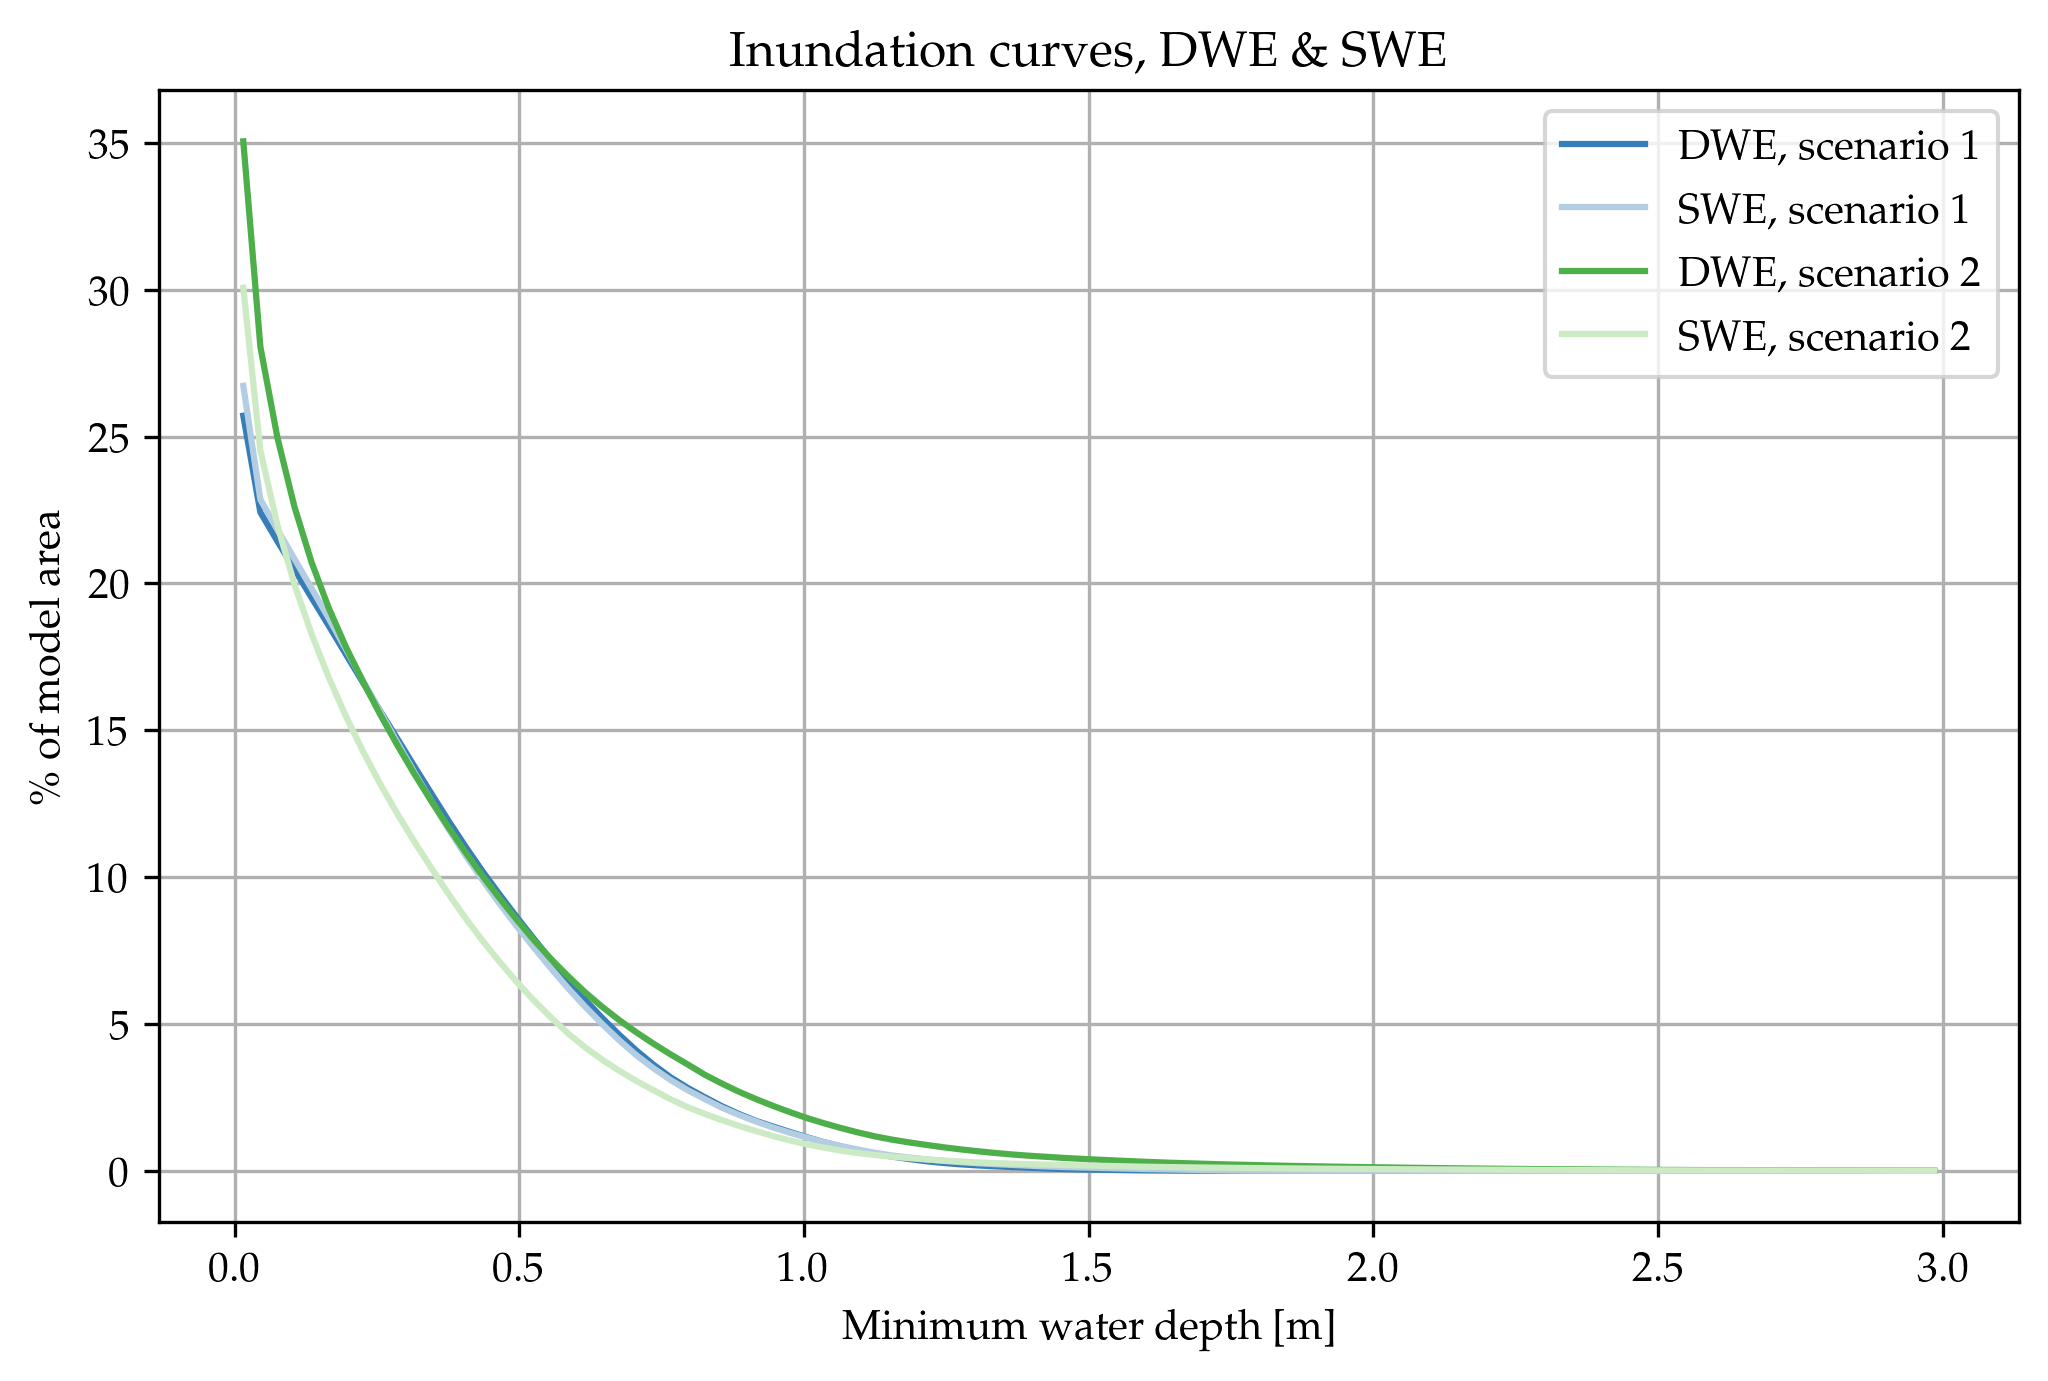

In [18]:
cmap1 = plt.get_cmap("Pastel1",9)
cmap2 = plt.get_cmap("Set1",9)
SWE = '_SWE'

plt.figure(figsize=[8,5])
for sc in range(1,9):
        hist = np.load("Hist_"+str(sc)+".npy",allow_pickle=True)
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist[0]/Area*100))),label='DWE, scenario '+str(sc),color=cmap2(sc))
        hist = np.load("Hist_"+str(sc)+SWE+".npy",allow_pickle=True)
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist[0]/Area*100))),label='SWE, scenario '+str(sc),color=cmap1(sc))
plt.grid()
# plt.xlim(None,2.5)
plt.xlabel("Minimum water depth [m]")
plt.ylabel('\% of model area')
plt.legend(loc='upper right')
plt.title('Inundation curves, DWE \& SWE')
# plt.ylim(-0.1, 3)

Text(0.5, 1.0, 'Inundation curves, DWE \\& SWE')

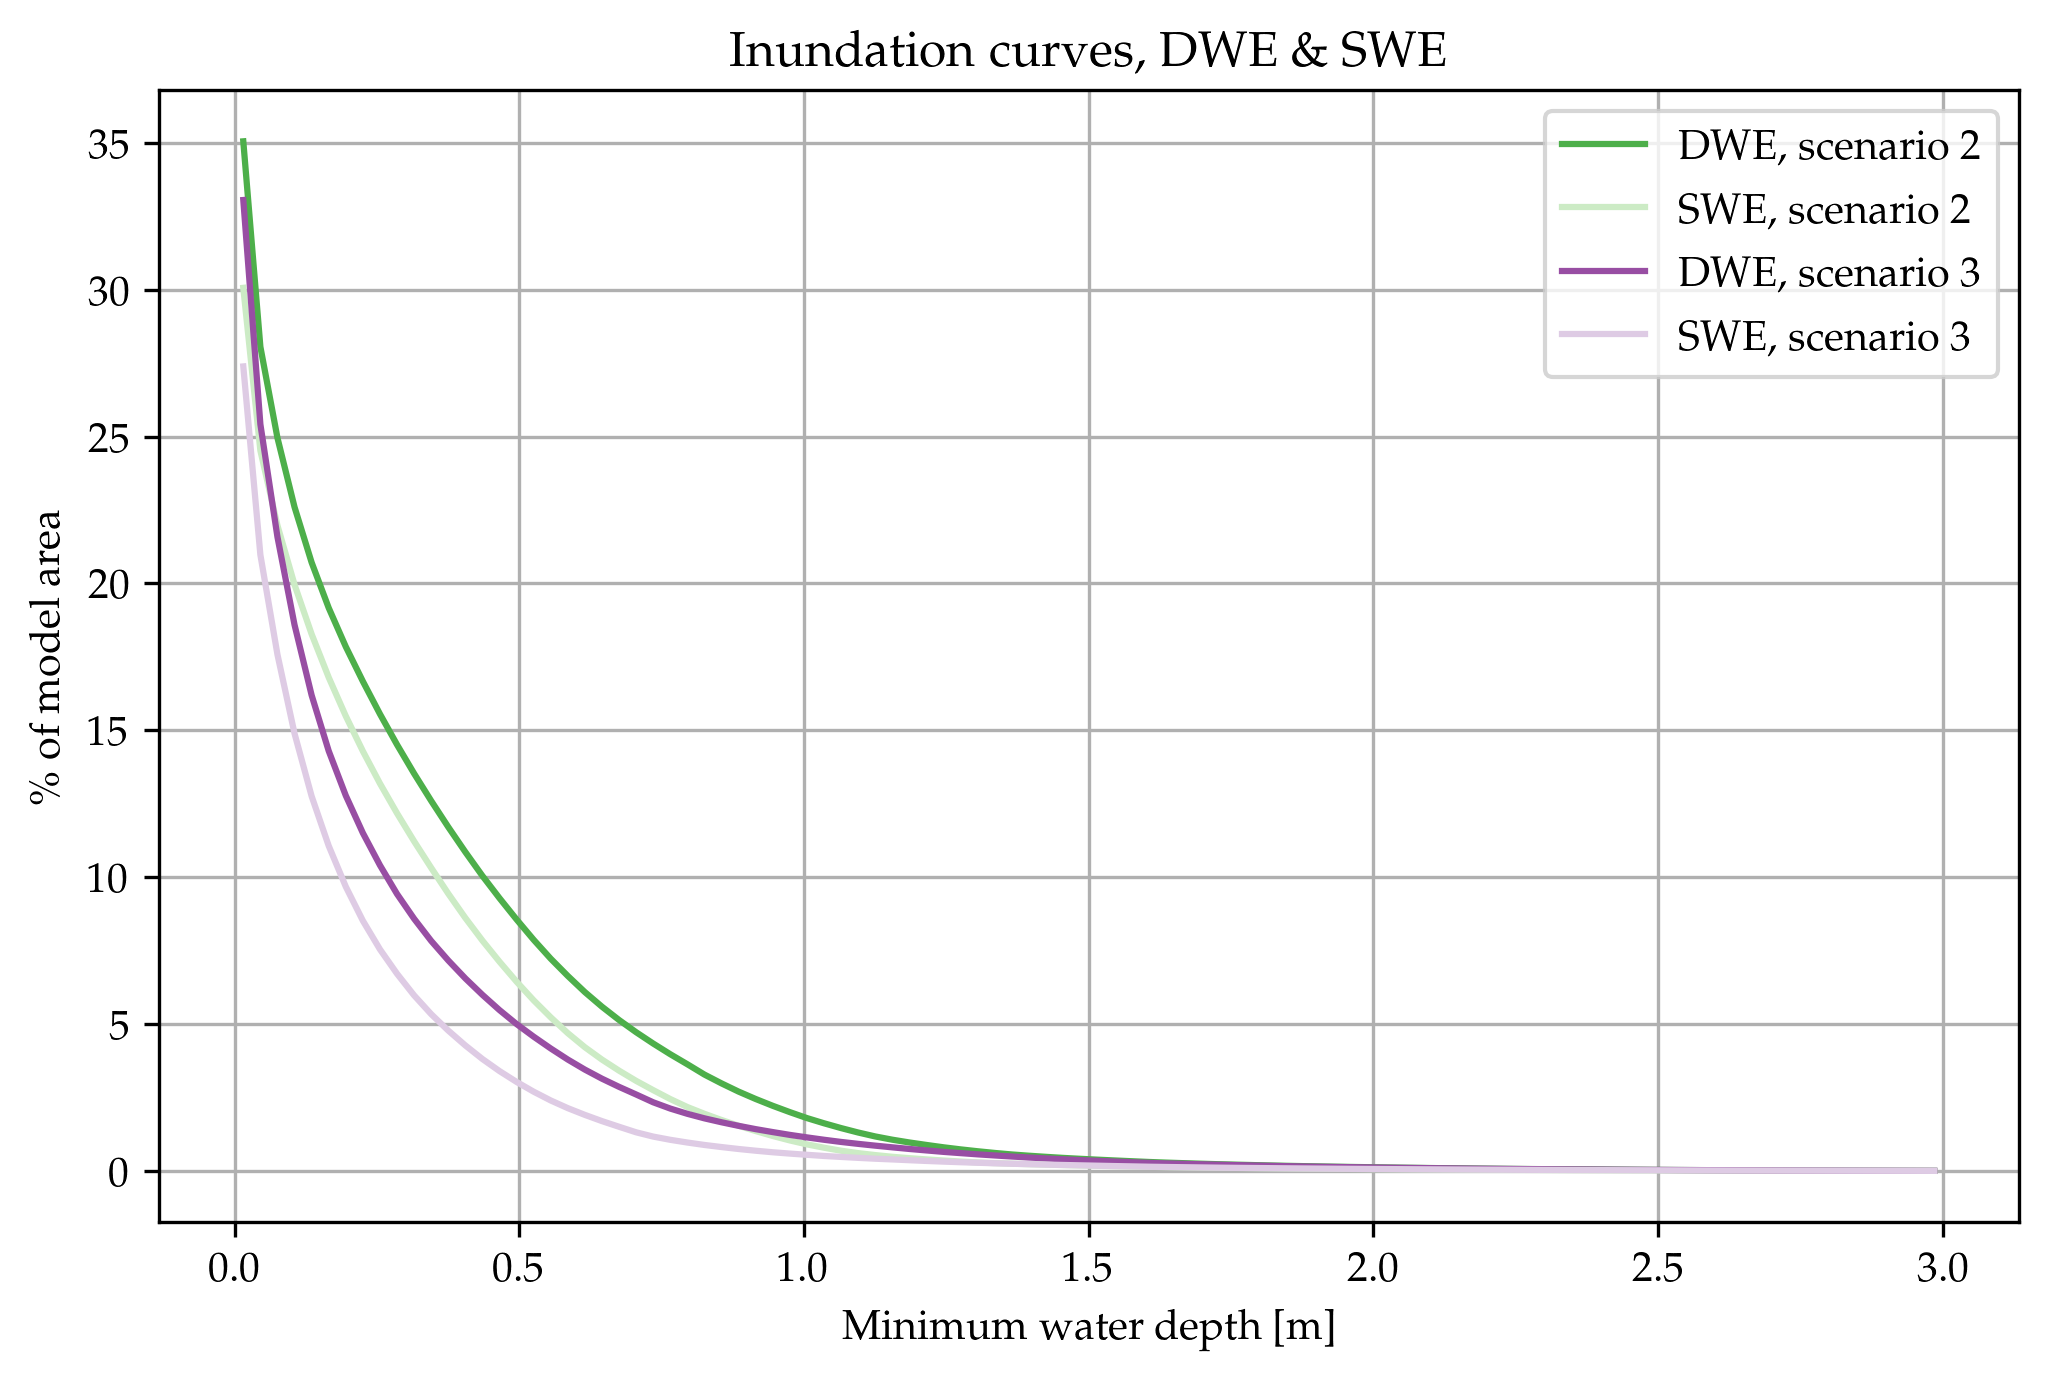

In [8]:
cmap1 = plt.get_cmap("Pastel1",9)
cmap2 = plt.get_cmap("Set1",9)
SWE = '_SWE'

plt.figure(figsize=[8,5])
for sc in range(2,4):
        hist = np.load("Hist_"+str(sc)+".npy",allow_pickle=True)
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist[0]/Area*100))),label='DWE, scenario '+str(sc),color=cmap2(sc))
        hist = np.load("Hist_"+str(sc)+SWE+".npy",allow_pickle=True)
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),np.flip(np.cumsum(np.flip(hist[0]/Area*100))),label='SWE, scenario '+str(sc),color=cmap1(sc))
plt.grid()
# plt.xlim(None,2.5)
plt.xlabel("Minimum water depth [m]")
plt.ylabel('\% of model area')
plt.legend(loc='upper right')
plt.title('Inundation curves, DWE \& SWE')
# plt.ylim(-0.1, 3)

Text(0.5, 1.0, 'Inundation curves, $DSW - SWE$')

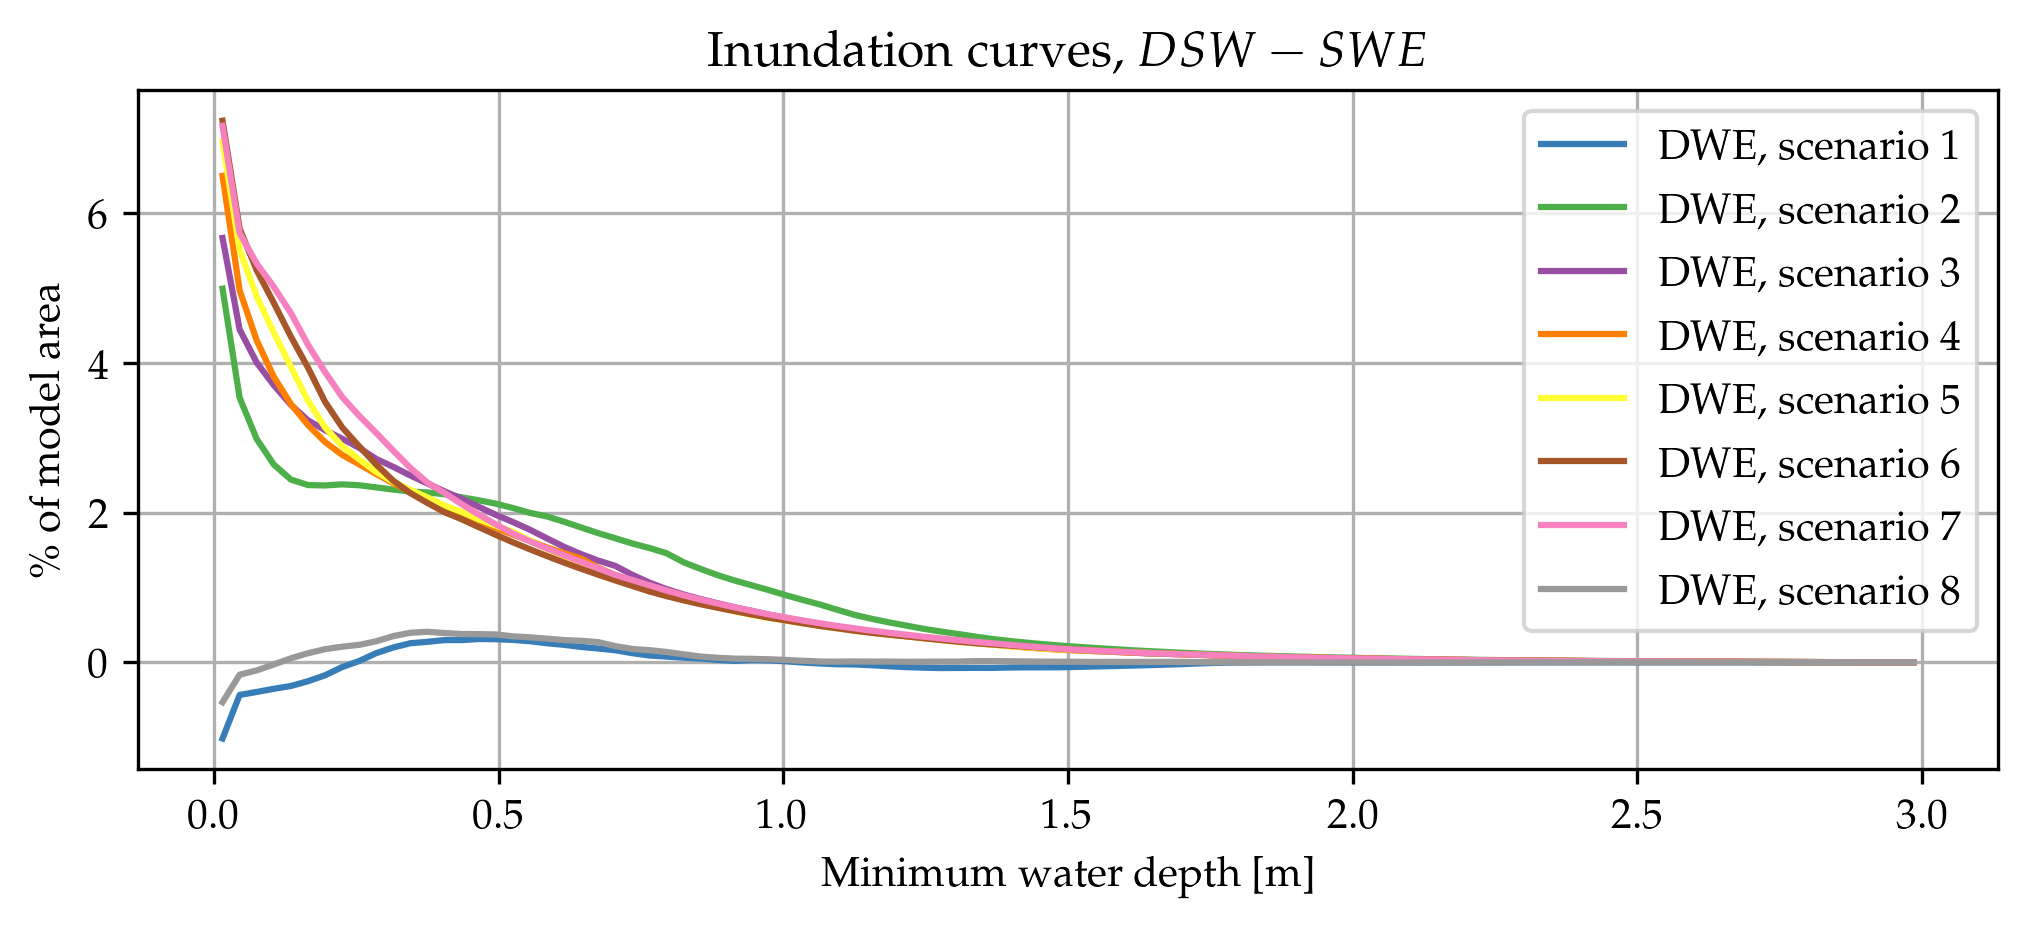

In [9]:
cmap1 = plt.get_cmap("Pastel1",9)
cmap2 = plt.get_cmap("Set1",9)
SWE = '_SWE'

plt.figure(figsize=[8,3])
for sc in range(1,9):
        hist = np.load("Hist_"+str(sc)+".npy",allow_pickle=True)
        hist2 = np.load("Hist_"+str(sc)+SWE+".npy",allow_pickle=True)
        plt.plot(np.linspace(np.mean(hist[1][0:2]),np.mean(hist[1][-2:]),len(hist[1])-1),(np.flip(np.cumsum(np.flip(hist[0]/Area*100)))-np.flip(np.cumsum(np.flip(hist2[0]/Area*100)))),label='DWE, scenario '+str(sc),color=cmap2(sc))
plt.grid()
# plt.xlim(None,2.5)
plt.xlabel("Minimum water depth [m]")
plt.ylabel('\% of model area')
plt.legend(loc='upper right')
plt.title('Inundation curves, $DSW - SWE$')
# plt.ylim(-0.1, 3)